/var/folders/ft/tdx4j_ks1s33pn4xyp1nq6km0000gn/T/ipykernel_81180/2329427074.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


[[ 250 2402  681 2917]]
(250, 1715, 681, 2230)


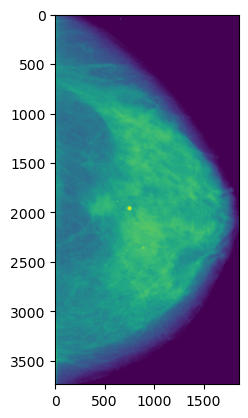

In [6]:
import os
import sys

from IPython.core.display import display

import os
import dicomsdl
# import argparse
from tqdm.auto import tqdm
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# import torch
# import timm
# import nvidia.dali.types as types
import cv2
def np_CountUpContinuingOnes(b_arr):
    # indice continuing zeros from left side.
    # ex: [0,1,1,0,1,0,0,1,1,1,0] -> [0,0,0,3,3,5,6,6,6,6,10]
    left = np.arange(len(b_arr))
    left[b_arr > 0] = 0
    left = np.maximum.accumulate(left)

    # from right side.
    # ex: [0,1,1,0,1,0,0,1,1,1,0] -> [0,3,3,3,5,5,6,10,10,10,10]
    rev_arr = b_arr[::-1]
    right = np.arange(len(rev_arr))
    right[rev_arr > 0] = 0
    right = np.maximum.accumulate(right)
    right = len(rev_arr) - 1 - right[::-1]

    return right - left - 1


def adjust_bounding_box(original_coords, left_crop, top_crop):
    x1, y1, x2, y2 = original_coords

    x1_new = x1 - left_crop
    y1_new = y1 - top_crop
    x2_new = x2 - left_crop
    y2_new = y2 - top_crop

    return x1_new, y1_new, x2_new, y2_new


def ExtractBreast(img, mask, true_bounding_box):
    img_copy = img.copy()
    mask_copy = mask.copy()

    # 将像素值小于等于20的部分设为0，以便更容易检测背景
    img = np.where(img <= 20, 0, img)
    height, _ = img.shape

    # 处理列方向（垂直方向）
    y_a = height // 2 + int(height * 0.4)
    y_b = height // 2 - int(height * 0.4)
    b_arr = img[y_b:y_a].std(axis=0) != 0
    continuing_ones = np_CountUpContinuingOnes(b_arr)
    # 最长的非零区域应为乳房部分
    col_ind = np.where(continuing_ones == continuing_ones.max())[0]
    
    # 对图像和掩码进行列裁剪
    img = img[:, col_ind]
    mask = mask[:, col_ind]

    # 处理行方向（水平方向）
    _, width = img.shape
    x_a = width // 2 + int(width * 0.4)
    x_b = width // 2 - int(width * 0.4)
    b_arr = img[:, x_b:x_a].std(axis=1) != 0
    continuing_ones = np_CountUpContinuingOnes(b_arr)
    # 最长的非零区域应为乳房部分
    row_ind = np.where(continuing_ones == continuing_ones.max())[0]
    
    # 对图像和掩码进行行裁剪
    img = img[row_ind, :]
    mask = mask[row_ind, :]

    # 调整边界框坐标
    adjusted_coords = adjust_bounding_box(true_bounding_box, col_ind[0], row_ind[0])

    return img_copy[row_ind][:, col_ind], mask_copy[row_ind][:, col_ind], adjusted_coords

bbox=np.load('/Volumes/图图/CBIS-DDSM_kaggle/CBIS-DDSM/Train/Mass-Training_P_00001_LEFT_CC/bboxes.npy',allow_pickle=True)
print(bbox)
mask = cv2.imread('/Volumes/图图/CBIS-DDSM_kaggle/CBIS-DDSM/Train/Mass-Training_P_00001_LEFT_CC/mask.png', cv2.IMREAD_GRAYSCALE)
img=cv2.imread('/Volumes/图图/CBIS-DDSM_kaggle/CBIS-DDSM/Train/Mass-Training_P_00001_LEFT_CC/img.jpg', cv2.IMREAD_GRAYSCALE)
img_new,mask_new,bbox_new=ExtractBreast(img,mask,bbox[0])
plt.imshow(img_new)
print(bbox_new)
output_dir='/Volumes/图图/CBIS-DDSM_kaggle/CBIS-DDSM/Train/Mass-Training_P_00001_LEFT_CC/new'
img_output_path = os.path.join(output_dir, 'img.jpg')
cv2.imwrite(img_output_path, cv2.normalize(img_new, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

mask_output_path = os.path.join(output_dir, 'mask.png')
cv2.imwrite(mask_output_path, mask_new)

bbox_output_path = os.path.join(output_dir, 'bboxes.npy')
np.save(bbox_output_path, bbox_new)

Segmentation

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import pydicom as pdcm
from tqdm import tqdm
def np_CountUpContinuingOnes(b_arr):
    # indice continuing zeros from left side.
    # ex: [0,1,1,0,1,0,0,1,1,1,0] -> [0,0,0,3,3,5,6,6,6,6,10]
    left = np.arange(len(b_arr))
    left[b_arr > 0] = 0
    left = np.maximum.accumulate(left)

    # from right side.
    # ex: [0,1,1,0,1,0,0,1,1,1,0] -> [0,3,3,3,5,5,6,10,10,10,10]
    rev_arr = b_arr[::-1]
    right = np.arange(len(rev_arr))
    right[rev_arr > 0] = 0
    right = np.maximum.accumulate(right)
    right = len(rev_arr) - 1 - right[::-1]

    return right - left - 1
def ExtractBreast(img, mask):
    img_copy = img.copy()
    mask_copy = mask.copy()
    
    # 处理图像，将背景区域设置为0
    img = np.where(img <= 20, 0, img)
    height, _ = img.shape

    # 处理列方向
    y_a = height // 2 + int(height * 0.4)
    y_b = height // 2 - int(height * 0.4)
    b_arr = img[y_b:y_a].std(axis=0) != 0
    continuing_ones = np_CountUpContinuingOnes(b_arr)
    col_ind = np.where(continuing_ones == continuing_ones.max())[0]
    
    # 对图像和掩码进行列裁剪
    img = img[:, col_ind]
    mask = mask[:, col_ind]

    # 处理行方向
    _, width = img.shape
    x_a = width // 2 + int(width * 0.4)
    x_b = width // 2 - int(width * 0.4)
    b_arr = img[:, x_b:x_a].std(axis=1) != 0
    continuing_ones = np_CountUpContinuingOnes(b_arr)
    row_ind = np.where(continuing_ones == continuing_ones.max())[0]
    
    # 对图像和掩码进行行裁剪
    img = img[row_ind, :]
    mask = mask[row_ind, :]

    return img_copy[row_ind][:, col_ind], mask_copy[row_ind][:, col_ind]

# 读取CSV文件并更新image_path列
dataset_dir = "/Volumes/图图/CBIS-DDSM_kaggle"
df = pd.read_csv(f'{dataset_dir}/csv/dicom_info.csv')
df['image_path'] = df.image_path.apply(lambda x: x.replace('CBIS-DDSM', dataset_dir))
df = df[df['PatientID'].str.contains('mass', case=False)]
# 初始化字典保存数据
masks = {}

# 遍历DataFrame的每一行
for index, row in tqdm(df.iterrows()):
    series_desc = row['SeriesDescription']
    patient_id = row['PatientID']
    
    if series_desc == 'full mammogram images':
        img_path = row['image_path']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if patient_id in masks:
            if masks[patient_id].shape != img.shape:
                print(f"Skipping {patient_id} due to size mismatch.")
                del masks[patient_id]  # 删除不匹配的mask
                continue
        else:
            mask = np.zeros_like(img, dtype=np.uint8)
            masks[patient_id] = mask
    elif series_desc == 'ROI mask images':
        base_patient_id = '_'.join(patient_id.split('_')[:-1])
        mask_path = row['image_path']
        roi_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if base_patient_id not in masks:
            masks[base_patient_id] = roi_mask
        else:
            if masks[base_patient_id].shape != roi_mask.shape:
                print(f"Skipping {base_patient_id} due to size mismatch.")
                del masks[base_patient_id]  # 删除不匹配的mask
                continue
            masks[base_patient_id] = np.maximum(masks[base_patient_id], roi_mask)

# 保存图像和mask
target_dir = "/Volumes/图图/CBIS-DDSM_kaggle/seg&det"
for patient_id, mask in masks.items():
    img_path = df.loc[df['PatientID'] == patient_id, 'image_path'].values[0]
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    img, mask = ExtractBreast(img, mask)
    # bboxes = find_bboxes_from_mask(mask)
    
    folder_type = "Train" if "Training" in patient_id else "Test"
    output_dir = os.path.join(target_dir, folder_type, patient_id)
    os.makedirs(output_dir, exist_ok=True)
    
    img_output_path = os.path.join(output_dir, 'img.jpg')
    cv2.imwrite(img_output_path, cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))
    
    mask_output_path = os.path.join(output_dir, 'mask.png')
    cv2.imwrite(mask_output_path, mask)
    
    # bbox_output_path = os.path.join(output_dir, 'bboxes.npy')
    # np.save(bbox_output_path, bboxes)
    
    print(f'Saved {patient_id} images and masks to {output_dir}')


285it [00:12, 21.42it/s]

Skipping Mass-Training_P_00436_LEFT_CC due to size mismatch.


341it [00:14, 30.50it/s]

Skipping Mass-Test_P_00145_LEFT_CC due to size mismatch.


433it [00:18, 23.14it/s]

Skipping Mass-Training_P_00765_RIGHT_MLO due to size mismatch.


1114it [00:47, 15.54it/s]

Skipping Mass-Training_P_01363_RIGHT_MLO due to size mismatch.


1296it [00:54, 25.60it/s]

Skipping Mass-Test_P_00922_RIGHT_MLO due to size mismatch.


1430it [01:01, 22.44it/s]

Skipping Mass-Training_P_01946_RIGHT_MLO due to size mismatch.


1463it [01:02, 26.05it/s]

Skipping Mass-Training_P_00949_LEFT_CC due to size mismatch.


1501it [01:03, 28.42it/s]

Skipping Mass-Training_P_00915_RIGHT_CC due to size mismatch.
Skipping Mass-Training_P_00059_LEFT_MLO due to size mismatch.


1591it [01:07, 24.77it/s]

Skipping Mass-Training_P_00108_LEFT_CC due to size mismatch.


1607it [01:08, 24.38it/s]

Skipping Mass-Training_P_01486_RIGHT_CC due to size mismatch.


1641it [01:09, 27.05it/s]

Skipping Mass-Training_P_02079_RIGHT_CC due to size mismatch.
Skipping Mass-Training_P_01714_RIGHT_MLO due to size mismatch.


1690it [01:11, 12.68it/s]

Skipping Mass-Test_P_00381_LEFT_MLO due to size mismatch.


1716it [01:12, 23.17it/s]

Skipping Mass-Training_P_02092_LEFT_CC due to size mismatch.


1816it [01:17, 21.40it/s]

Skipping Mass-Test_P_00381_LEFT_CC due to size mismatch.


1882it [01:20, 19.99it/s]

Skipping Mass-Training_P_01981_RIGHT_CC due to size mismatch.


1945it [01:22, 25.26it/s]

Skipping Mass-Training_P_01486_RIGHT_MLO due to size mismatch.


2132it [01:30, 38.33it/s]

Skipping Mass-Training_P_00949_LEFT_MLO due to size mismatch.


2195it [01:33, 26.41it/s]

Skipping Mass-Training_P_01423_RIGHT_MLO due to size mismatch.


2258it [01:35, 26.39it/s]

Skipping Mass-Training_P_00826_LEFT_CC due to size mismatch.


2363it [01:40, 28.52it/s]

Skipping Mass-Training_P_01115_RIGHT_MLO due to size mismatch.


2370it [01:40, 28.75it/s]

Skipping Mass-Test_P_01595_LEFT_CC due to size mismatch.
Skipping Mass-Training_P_01981_RIGHT_MLO due to size mismatch.


2395it [01:41, 31.05it/s]

Skipping Mass-Training_P_00384_RIGHT_CC due to size mismatch.


2449it [01:43, 33.54it/s]

Skipping Mass-Training_P_01983_LEFT_MLO due to size mismatch.


2490it [01:45, 22.53it/s]

Skipping Mass-Training_P_00687_LEFT_CC due to size mismatch.


2557it [01:49, 20.86it/s]

Skipping Mass-Test_P_00699_RIGHT_CC due to size mismatch.


2570it [01:49, 21.41it/s]

Skipping Mass-Test_P_01551_LEFT_CC due to size mismatch.


2644it [01:52, 24.24it/s]

Skipping Mass-Training_P_01243_LEFT_MLO due to size mismatch.


2680it [01:54, 21.50it/s]

Skipping Mass-Training_P_00859_LEFT_CC due to size mismatch.


2717it [01:56, 19.11it/s]

Skipping Mass-Training_P_01423_RIGHT_CC due to size mismatch.


2743it [01:57, 20.74it/s]

Skipping Mass-Training_P_00694_RIGHT_CC due to size mismatch.


2761it [01:58, 17.53it/s]

Skipping Mass-Training_P_00436_LEFT_MLO due to size mismatch.


2779it [01:59, 19.40it/s]

Skipping Mass-Training_P_01686_RIGHT_CC due to size mismatch.


2996it [02:09, 32.07it/s]

Skipping Mass-Test_P_01595_LEFT_MLO due to size mismatch.


3030it [02:10, 26.91it/s]

Skipping Mass-Training_P_01115_RIGHT_CC due to size mismatch.
Skipping Mass-Training_P_00453_LEFT_MLO due to size mismatch.


3146it [02:15, 30.08it/s]

Skipping Mass-Training_P_00715_RIGHT_CC due to size mismatch.


3175it [02:16, 38.70it/s]

Skipping Mass-Training_P_02033_RIGHT_CC due to size mismatch.
Skipping Mass-Training_P_01757_RIGHT_CC due to size mismatch.


3372it [02:23, 31.97it/s]

Skipping Mass-Training_P_00304_LEFT_MLO due to size mismatch.


3501it [02:27, 26.28it/s]

Skipping Mass-Training_P_00826_LEFT_MLO due to size mismatch.


3524it [02:28, 37.71it/s]

Skipping Mass-Training_P_02092_LEFT_MLO due to size mismatch.


3532it [02:28, 31.14it/s]

Skipping Mass-Training_P_01831_RIGHT_CC due to size mismatch.


3665it [02:33, 25.04it/s]

Skipping Mass-Training_P_01048_RIGHT_MLO due to size mismatch.


3685it [02:34, 22.03it/s]

Skipping Mass-Training_P_01714_RIGHT_CC due to size mismatch.


3698it [02:35, 13.58it/s]

Skipping Mass-Training_P_00384_RIGHT_MLO due to size mismatch.


3710it [02:35, 23.92it/s]

Skipping Mass-Training_P_02079_RIGHT_MLO due to size mismatch.


3713it [02:35, 20.06it/s]

Skipping Mass-Test_P_00379_LEFT_MLO due to size mismatch.


3773it [02:37, 32.74it/s]

Skipping Mass-Training_P_00915_RIGHT_MLO due to size mismatch.
Skipping Mass-Training_P_01182_LEFT_MLO due to size mismatch.


3954it [02:43, 25.22it/s]

Skipping Mass-Training_P_01363_RIGHT_CC due to size mismatch.


3962it [02:43, 29.96it/s]

Skipping Mass-Test_P_00699_RIGHT_MLO due to size mismatch.
Skipping Mass-Training_P_00694_RIGHT_MLO due to size mismatch.


3992it [02:44, 27.99it/s]

Skipping Mass-Test_P_00922_RIGHT_CC due to size mismatch.


4019it [02:45, 31.75it/s]

Skipping Mass-Training_P_00108_LEFT_MLO due to size mismatch.


4071it [02:47, 27.90it/s]

Skipping Mass-Test_P_00145_LEFT_MLO due to size mismatch.


4174it [02:51, 26.46it/s]

Skipping Mass-Training_P_00703_LEFT_CC due to size mismatch.


4196it [02:52, 25.59it/s]

Skipping Mass-Training_P_01048_RIGHT_CC due to size mismatch.


4225it [02:53, 19.54it/s]

Skipping Mass-Training_P_01908_LEFT_CC due to size mismatch.


4236it [02:53, 28.34it/s]

Skipping Mass-Training_P_01243_LEFT_CC due to size mismatch.


4328it [02:56, 25.83it/s]

Skipping Mass-Training_P_01757_RIGHT_MLO due to size mismatch.


4362it [02:58, 27.88it/s]

Skipping Mass-Training_P_00423_RIGHT_CC due to size mismatch.


4392it [02:59, 19.99it/s]

Skipping Mass-Test_P_01378_RIGHT_CC due to size mismatch.
Skipping Mass-Training_P_00715_RIGHT_MLO due to size mismatch.


4411it [03:00, 25.86it/s]

Skipping Mass-Training_P_00687_LEFT_MLO due to size mismatch.


4428it [03:01, 29.37it/s]

Skipping Mass-Training_P_01831_RIGHT_MLO due to size mismatch.


4504it [03:03, 33.16it/s]

Skipping Mass-Training_P_00859_LEFT_MLO due to size mismatch.


4519it [03:04, 29.73it/s]

Skipping Mass-Training_P_00279_LEFT_CC due to size mismatch.


4587it [03:06, 29.51it/s]

Skipping Mass-Training_P_00765_RIGHT_CC due to size mismatch.


4628it [03:08, 28.24it/s]

Skipping Mass-Training_P_00453_LEFT_CC due to size mismatch.


4673it [03:09, 25.22it/s]

Skipping Mass-Training_P_01182_LEFT_CC due to size mismatch.


4717it [03:11, 27.05it/s]

Skipping Mass-Training_P_00927_LEFT_MLO due to size mismatch.


4744it [03:12, 21.27it/s]

Skipping Mass-Training_P_01686_RIGHT_MLO due to size mismatch.


4769it [03:13, 28.69it/s]

Skipping Mass-Training_P_02033_RIGHT_MLO due to size mismatch.


4810it [03:14, 30.28it/s]

Skipping Mass-Training_P_00059_LEFT_CC due to size mismatch.


4946it [03:19, 28.98it/s]

Skipping Mass-Training_P_00703_LEFT_MLO due to size mismatch.


4984it [03:20, 24.84it/s]


Saved Mass-Training_P_01754_RIGHT_CC images and masks to /Volumes/图图/CBIS-DDSM_kaggle/image_seg/Train/Mass-Training_P_01754_RIGHT_CC
Saved Mass-Training_P_01206_RIGHT_MLO images and masks to /Volumes/图图/CBIS-DDSM_kaggle/image_seg/Train/Mass-Training_P_01206_RIGHT_MLO
Saved Mass-Training_P_00242_RIGHT_CC images and masks to /Volumes/图图/CBIS-DDSM_kaggle/image_seg/Train/Mass-Training_P_00242_RIGHT_CC
Saved Mass-Training_P_00122_RIGHT_MLO images and masks to /Volumes/图图/CBIS-DDSM_kaggle/image_seg/Train/Mass-Training_P_00122_RIGHT_MLO
Saved Mass-Training_P_01175_RIGHT_MLO images and masks to /Volumes/图图/CBIS-DDSM_kaggle/image_seg/Train/Mass-Training_P_01175_RIGHT_MLO
Saved Mass-Training_P_00411_RIGHT_CC images and masks to /Volumes/图图/CBIS-DDSM_kaggle/image_seg/Train/Mass-Training_P_00411_RIGHT_CC
Saved Mass-Training_P_00634_RIGHT_MLO images and masks to /Volumes/图图/CBIS-DDSM_kaggle/image_seg/Train/Mass-Training_P_00634_RIGHT_MLO
Saved Mass-Test_P_00882_RIGHT_CC images and masks to /Volumes

Detection

In [15]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

def find_cropped_image_position(full_image, cropped_image):
    res = cv2.matchTemplate(full_image, cropped_image, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + cropped_image.shape[1], top_left[1] + cropped_image.shape[0])
    return (*top_left, *bottom_right)

dataset_dir = "/Volumes/图图/CBIS-DDSM_kaggle"
df = pd.read_csv(f'{dataset_dir}/csv/dicom_info.csv')
df['image_path'] = df.image_path.apply(lambda x: x.replace('CBIS-DDSM', dataset_dir))
df = df[df['PatientID'].str.contains('mass', case=False)]

# 初始化字典保存数据
cropped = {}
data_path = '/Volumes/图图/CBIS-DDSM_kaggle/seg&det'
target_dir = "/Volumes/图图/CBIS-DDSM_kaggle/seg&det"
# 遍历DataFrame的每一行
for index, row in tqdm(df.iterrows()):
    series_desc = row['SeriesDescription']
    patient_id = row['PatientID']
    
    if series_desc == 'cropped images':
        base_patient_id = '_'.join(patient_id.split('_')[:-1])
        cropped_path = row['image_path']
        cropped_image = cv2.imread(cropped_path, cv2.IMREAD_GRAYSCALE)
        
        if base_patient_id.split('_')[0].split('-')[1] == 'Training':
            original_image_path = os.path.join(data_path, 'Train', base_patient_id, 'img.jpg')
        else:
            original_image_path = os.path.join(data_path, 'Test', base_patient_id, 'img.jpg')
        original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
        if original_image is None:
            continue
        # print(original_image.shape)
        # print(cropped_image.shape)
        boxes = find_cropped_image_position(original_image, cropped_image)
        
        if base_patient_id not in cropped:
            cropped[base_patient_id] = [boxes]
        else:
            cropped[base_patient_id].append(boxes)

# 保存边界框信息

for patient_id, boxes in cropped.items():
    folder_type = "Train" if "Training" in patient_id else "Test"
    output_dir = os.path.join(target_dir, folder_type, patient_id)
    os.makedirs(output_dir, exist_ok=True)
    
    bbox_output_path = os.path.join(output_dir, 'bboxes.npy')
    np.save(bbox_output_path, boxes)
    
    print(f'Saved {patient_id} bboxes to {output_dir}')


4984it [09:22,  8.85it/s]


Saved Mass-Training_P_01265_RIGHT_MLO bboxes to /Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_01265_RIGHT_MLO
Saved Mass-Training_P_00242_RIGHT_CC bboxes to /Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_00242_RIGHT_CC
Saved Mass-Training_P_00634_RIGHT_MLO bboxes to /Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_00634_RIGHT_MLO
Saved Mass-Test_P_00882_RIGHT_CC bboxes to /Volumes/图图/CBIS-DDSM_kaggle/seg&det/Test/Mass-Test_P_00882_RIGHT_CC
Saved Mass-Training_P_00241_RIGHT_CC bboxes to /Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_00241_RIGHT_CC
Saved Mass-Training_P_00348_LEFT_MLO bboxes to /Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_00348_LEFT_MLO
Saved Mass-Training_P_00259_RIGHT_MLO bboxes to /Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_00259_RIGHT_MLO
Saved Mass-Training_P_00248_LEFT_MLO bboxes to /Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_00248_LEFT_MLO
Saved Mass-Test_P_00391_RIGHT_CC bb

cropped-segmentation

In [16]:
import os
import numpy as np
from PIL import Image
import shutil

def crop_and_save(image, mask, bbox, output_dir):
    x1, y1, x2, y2 = bbox
    # Crop the image and mask
    cropped_image = image.crop((x1, y1, x2, y2))
    cropped_mask = mask.crop((x1, y1, x2, y2))

    # Save the cropped image and mask
    cropped_image.save(os.path.join(output_dir, 'img.jpg'))
    cropped_mask.save(os.path.join(output_dir, 'mask.png'))

def process_directory(input_dir, output_base_dir):
    # Walk through each folder in the directory
    for root, dirs, files in os.walk(input_dir):
        if 'bboxes.npy' in files:
            # Load bbox coordinates
            
            bbox_file = os.path.join(root, 'bboxes.npy')
            print(bbox_file)
            bboxes = np.load(bbox_file)
            print(bboxes)
            # Load the image and mask
            image_file = os.path.join(root, 'img.jpg')
            mask_file = os.path.join(root, 'mask.png')
            image = Image.open(image_file)
            mask = Image.open(mask_file)
            
            # Create corresponding output directory
            relative_path = os.path.relpath(root, input_dir)
            output_dir = os.path.join(output_base_dir, relative_path)
            # os.makedirs(output_dir, exist_ok=True)
            
            # Process each bbox
            for i, bbox in enumerate(bboxes):
                # Create subdirectory for each cropped image
                cropped_output_dir = output_dir+f'_{i}'
                os.makedirs(cropped_output_dir, exist_ok=True)
                
                # Crop and save
                crop_and_save(image, mask, bbox, cropped_output_dir)
                

def main():
    base_dir = '/Volumes/图图/CBIS-DDSM_kaggle/seg&det'  # Modify with actual base directory
    output_dir = '/Volumes/图图/CBIS-DDSM_kaggle/cropped_seg'  # Modify with desired output directory

    # Ensure the output directory is clean
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    
    # Process Train and Test directories
    train_dir = os.path.join(base_dir, 'Train')
    test_dir = os.path.join(base_dir, 'Test')
    
    process_directory(train_dir, output_dir+'/Train')
    process_directory(test_dir, output_dir+'/Test')

if __name__ == '__main__':
    main()


/Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_01754_RIGHT_CC/bboxes.npy
[[  91 1348  376 1602]]
/Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_01206_RIGHT_MLO/bboxes.npy
[[1081 2469 1452 2889]]
/Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_00242_RIGHT_CC/bboxes.npy
[[ 338 1910  703 2253]]
/Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_00122_RIGHT_MLO/bboxes.npy
[[ 720 1524 1008 1798]]
/Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_01175_RIGHT_MLO/bboxes.npy
[[ 705 3096 1062 3343]]
/Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_00411_RIGHT_CC/bboxes.npy
[[ 254 1084  618 1494]]
/Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_00634_RIGHT_MLO/bboxes.npy
[[ 722 1270 1052 1762]]
/Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_00004_LEFT_MLO/bboxes.npy
[[ 882 3027 1304 3454]]
/Volumes/图图/CBIS-DDSM_kaggle/seg&det/Train/Mass-Training_P_01946_RIGHT_CC/bboxes.npy
[[1170  755 1652 1206]]
/Volumes/图图/CBI

image-Classification

In [8]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import pydicom as pdcm

def np_CountUpContinuingOnes(b_arr):
    # indice continuing zeros from left side.
    # ex: [0,1,1,0,1,0,0,1,1,1,0] -> [0,0,0,3,3,5,6,6,6,6,10]
    left = np.arange(len(b_arr))
    left[b_arr > 0] = 0
    left = np.maximum.accumulate(left)

    # from right side.
    # ex: [0,1,1,0,1,0,0,1,1,1,0] -> [0,3,3,3,5,5,6,10,10,10,10]
    rev_arr = b_arr[::-1]
    right = np.arange(len(rev_arr))
    right[rev_arr > 0] = 0
    right = np.maximum.accumulate(right)
    right = len(rev_arr) - 1 - right[::-1]

    return right - left - 1


def ExtractBreast(img):
    img_copy = img.copy()
    img = np.where(img <= 40, 0, img)  # To detect backgrounds easily
    height, _ = img.shape

    # whether each col is non-constant or not
    y_a = height // 2 + int(height * 0.4)
    y_b = height // 2 - int(height * 0.4)
    b_arr = img[y_b:y_a].std(axis=0) != 0
    continuing_ones = np_CountUpContinuingOnes(b_arr)
    # longest should be the breast
    col_ind = np.where(continuing_ones == continuing_ones.max())[0]
    img = img[:, col_ind]

    # whether each row is non-constant or not
    _, width = img.shape
    x_a = width // 2 + int(width * 0.4)
    x_b = width // 2 - int(width * 0.4)
    b_arr = img[:, x_b:x_a].std(axis=1) != 0
    continuing_ones = np_CountUpContinuingOnes(b_arr)
    # longest should be the breast
    row_ind = np.where(continuing_ones == continuing_ones.max())[0]

    return img_copy[row_ind][:, col_ind]

# 读取 CSV 文件并更新 image_path 列
dataset_dir = "/Volumes/图图/CBIS-DDSM_kaggle"
df = pd.read_csv(f'{dataset_dir}/csv/dicom_info.csv')
df['image_path'] = df['image_path'].apply(lambda x: x.replace('CBIS-DDSM', dataset_dir))

# 读取另一个 CSV 文件
# additional_info_path = "/Volumes/图图/CBIS-DDSM_kaggle/csv/mass_case_description_train_set.csv"  # 更新为你的文件路径
# additional_info_path = "/Volumes/图图/CBIS-DDSM_kaggle/csv/mass_case_description_test_set.csv"  # 更新为你的文件路径
# additional_info_path = "/Volumes/图图/CBIS-DDSM_kaggle/csv/calc_case_description_train_set.csv"  # 更新为你的文件路径
additional_info_path = "/Volumes/图图/CBIS-DDSM_kaggle/csv/calc_case_description_test_set.csv"  # 更新为你的文件路径
additional_df = pd.read_csv(additional_info_path)

# 初始化字典保存数据
category = {}

# 遍历 additional_df 的每一行
# target_dir = "/Volumes/图图/CBIS-DDSM_kaggle/image-classification/Train"
target_dir = "/Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test"
for index, row in tqdm(additional_df.iterrows(), total=len(additional_df)):
    patient_id = row['image file path'].split('/')[0]
    # 查找对应的图像信息
    img_row = df[df['image_path'].apply(lambda x: x.split('/')[-2]) ==row['image file path'].split('/')[-2]]
    # print(img_row)
    if img_row.empty:
        print(f"No image info for patient_id: {patient_id}")
        break
        
    
    img_path = img_row['image_path'].values[0]
    # series_desc = img_row['SeriesDescription'].values[0]
    # print(img_row['SeriesDescription'])
    # if series_desc == 'full mammogram images':
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Failed to read image: {img_path}")
        break
    
    img = ExtractBreast(img)
    
    # 构建字典
    info_dict = {
        "breast_density": str(row['breast density']).replace(' ',''),
        "left_or_right_breast": str(row['left or right breast']).replace(' ',''),
        "image_view": str(row['image view']).replace(' ','')
        # "abnormality_type": row['abnormality type'],
        # "assessment": row['assessment'],
        # "pathology": row['pathology'],
        # "subtlety": row['subtlety']
    }
    
    # 保存图像和字典
    output_dir = os.path.join(target_dir, patient_id)
    os.makedirs(output_dir, exist_ok=True)
    
    img_output_path = os.path.join(output_dir, 'img.jpg')
    cv2.imwrite(img_output_path, cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))
    
    dict_output_path = os.path.join(output_dir, 'info_dict.npy')
    np.save(dict_output_path, info_dict)
    
    print(f'Saved {patient_id} images and categories to {output_dir}')

print("Processing complete.")


  0%|          | 1/326 [00:00<02:51,  1.89it/s]

Saved Calc-Test_P_00038_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00038_LEFT_CC


  1%|          | 2/326 [00:01<02:57,  1.82it/s]

Saved Calc-Test_P_00038_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00038_LEFT_MLO


  1%|          | 3/326 [00:01<02:17,  2.36it/s]

Saved Calc-Test_P_00038_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00038_RIGHT_CC


  1%|          | 4/326 [00:01<01:55,  2.78it/s]

Saved Calc-Test_P_00038_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00038_RIGHT_CC


  2%|▏         | 5/326 [00:01<01:48,  2.95it/s]

Saved Calc-Test_P_00038_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00038_RIGHT_MLO


  2%|▏         | 6/326 [00:02<02:40,  1.99it/s]

Saved Calc-Test_P_00038_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00038_RIGHT_MLO


  2%|▏         | 7/326 [00:03<02:57,  1.80it/s]

Saved Calc-Test_P_00041_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00041_LEFT_CC


  2%|▏         | 8/326 [00:04<03:10,  1.67it/s]

Saved Calc-Test_P_00041_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00041_LEFT_MLO


  3%|▎         | 9/326 [00:04<03:06,  1.70it/s]

Saved Calc-Test_P_00077_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00077_LEFT_CC


  3%|▎         | 10/326 [00:05<03:27,  1.52it/s]

Saved Calc-Test_P_00077_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00077_LEFT_MLO


  3%|▎         | 11/326 [00:05<02:50,  1.84it/s]

Saved Calc-Test_P_00077_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00077_RIGHT_CC


  4%|▎         | 12/326 [00:06<02:22,  2.20it/s]

Saved Calc-Test_P_00077_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00077_RIGHT_CC


  4%|▍         | 13/326 [00:06<02:07,  2.45it/s]

Saved Calc-Test_P_00077_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00077_RIGHT_MLO


  4%|▍         | 14/326 [00:06<01:52,  2.77it/s]

Saved Calc-Test_P_00077_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00077_RIGHT_MLO


  5%|▍         | 15/326 [00:06<01:55,  2.70it/s]

Saved Calc-Test_P_00100_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00100_RIGHT_CC


  5%|▍         | 16/326 [00:07<02:22,  2.18it/s]

Saved Calc-Test_P_00100_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00100_RIGHT_MLO


  5%|▌         | 17/326 [00:08<02:36,  1.97it/s]

Saved Calc-Test_P_00127_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00127_RIGHT_CC


  6%|▌         | 18/326 [00:08<02:54,  1.76it/s]

Saved Calc-Test_P_00127_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00127_RIGHT_MLO


  6%|▌         | 19/326 [00:09<03:29,  1.47it/s]

Saved Calc-Test_P_00132_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00132_LEFT_MLO


  6%|▌         | 20/326 [00:10<02:48,  1.81it/s]

Saved Calc-Test_P_00140_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00140_LEFT_CC


  6%|▋         | 21/326 [00:10<02:19,  2.18it/s]

Saved Calc-Test_P_00140_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00140_LEFT_CC


  7%|▋         | 22/326 [00:10<02:12,  2.29it/s]

Saved Calc-Test_P_00140_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00140_LEFT_MLO


  7%|▋         | 23/326 [00:10<01:52,  2.69it/s]

Saved Calc-Test_P_00140_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00140_LEFT_MLO


  8%|▊         | 25/326 [00:11<01:52,  2.67it/s]

Saved Calc-Test_P_00140_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00140_RIGHT_CC
Saved Calc-Test_P_00140_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00140_RIGHT_CC


  8%|▊         | 27/326 [00:12<01:24,  3.54it/s]

Saved Calc-Test_P_00140_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00140_RIGHT_MLO
Saved Calc-Test_P_00140_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00140_RIGHT_MLO


  9%|▊         | 28/326 [00:12<01:46,  2.79it/s]

Saved Calc-Test_P_00141_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00141_LEFT_CC


  9%|▉         | 29/326 [00:13<01:56,  2.55it/s]

Saved Calc-Test_P_00141_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00141_LEFT_MLO


  9%|▉         | 30/326 [00:13<02:05,  2.36it/s]

Saved Calc-Test_P_00150_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00150_RIGHT_MLO


 10%|▉         | 31/326 [00:14<02:32,  1.94it/s]

Saved Calc-Test_P_00163_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00163_LEFT_CC


 10%|▉         | 32/326 [00:15<02:49,  1.74it/s]

Saved Calc-Test_P_00163_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00163_LEFT_MLO


 10%|█         | 33/326 [00:15<02:29,  1.96it/s]

Saved Calc-Test_P_00164_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00164_RIGHT_CC


 10%|█         | 34/326 [00:15<02:08,  2.27it/s]

Saved Calc-Test_P_00180_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00180_LEFT_CC


 11%|█         | 35/326 [00:16<02:23,  2.02it/s]

Saved Calc-Test_P_00180_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00180_LEFT_MLO


 11%|█         | 36/326 [00:16<02:19,  2.08it/s]

Saved Calc-Test_P_00195_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00195_LEFT_CC


 11%|█▏        | 37/326 [00:17<02:06,  2.28it/s]

Saved Calc-Test_P_00195_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00195_LEFT_MLO


 12%|█▏        | 38/326 [00:18<03:04,  1.56it/s]

Saved Calc-Test_P_00202_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00202_RIGHT_CC


 12%|█▏        | 39/326 [00:19<03:08,  1.53it/s]

Saved Calc-Test_P_00202_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00202_RIGHT_MLO


 12%|█▏        | 40/326 [00:19<02:47,  1.71it/s]

Saved Calc-Test_P_00214_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00214_LEFT_CC


 13%|█▎        | 41/326 [00:19<02:39,  1.79it/s]

Saved Calc-Test_P_00214_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00214_LEFT_CC


 13%|█▎        | 42/326 [00:20<02:12,  2.14it/s]

Saved Calc-Test_P_00214_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00214_LEFT_MLO


 13%|█▎        | 43/326 [00:20<01:50,  2.56it/s]

Saved Calc-Test_P_00214_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00214_LEFT_MLO


 13%|█▎        | 44/326 [00:20<01:39,  2.84it/s]

Saved Calc-Test_P_00214_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00214_RIGHT_MLO


 14%|█▍        | 45/326 [00:21<01:37,  2.87it/s]

Saved Calc-Test_P_00223_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00223_LEFT_MLO


 14%|█▍        | 46/326 [00:21<02:04,  2.26it/s]

Saved Calc-Test_P_00244_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00244_RIGHT_MLO


 14%|█▍        | 47/326 [00:22<02:35,  1.80it/s]

Saved Calc-Test_P_00246_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00246_RIGHT_MLO


 15%|█▍        | 48/326 [00:22<02:09,  2.15it/s]

Saved Calc-Test_P_00257_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00257_RIGHT_CC


 15%|█▌        | 49/326 [00:23<02:24,  1.91it/s]

Saved Calc-Test_P_00257_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00257_RIGHT_MLO


 15%|█▌        | 50/326 [00:23<02:21,  1.95it/s]

Saved Calc-Test_P_00299_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00299_LEFT_MLO


 16%|█▌        | 51/326 [00:24<02:16,  2.02it/s]

Saved Calc-Test_P_00299_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00299_RIGHT_CC


 16%|█▌        | 52/326 [00:25<02:36,  1.75it/s]

Saved Calc-Test_P_00299_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00299_RIGHT_MLO


 16%|█▋        | 53/326 [00:25<02:53,  1.57it/s]

Saved Calc-Test_P_00315_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00315_LEFT_MLO


 17%|█▋        | 54/326 [00:26<02:28,  1.83it/s]

Saved Calc-Test_P_00325_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00325_RIGHT_MLO


 17%|█▋        | 55/326 [00:27<02:56,  1.54it/s]

Saved Calc-Test_P_00331_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00331_LEFT_CC


 17%|█▋        | 56/326 [00:27<02:51,  1.58it/s]

Saved Calc-Test_P_00331_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00331_LEFT_MLO


 18%|█▊        | 58/326 [00:28<01:52,  2.38it/s]

Saved Calc-Test_P_00344_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00344_LEFT_CC
Saved Calc-Test_P_00344_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00344_LEFT_MLO


 18%|█▊        | 59/326 [00:28<01:33,  2.86it/s]

Saved Calc-Test_P_00352_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00352_LEFT_CC


 18%|█▊        | 60/326 [00:29<02:04,  2.13it/s]

Saved Calc-Test_P_00352_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00352_LEFT_MLO


 19%|█▊        | 61/326 [00:29<01:48,  2.45it/s]

Saved Calc-Test_P_00353_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00353_LEFT_CC


 19%|█▉        | 62/326 [00:29<01:38,  2.67it/s]

Saved Calc-Test_P_00353_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00353_LEFT_MLO


 19%|█▉        | 63/326 [00:29<01:30,  2.90it/s]

Saved Calc-Test_P_00353_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00353_LEFT_CC


 20%|█▉        | 64/326 [00:30<01:23,  3.12it/s]

Saved Calc-Test_P_00353_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00353_LEFT_MLO


 20%|█▉        | 65/326 [00:30<01:14,  3.49it/s]

Saved Calc-Test_P_00368_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00368_LEFT_CC


 20%|██        | 66/326 [00:30<01:08,  3.81it/s]

Saved Calc-Test_P_00368_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00368_LEFT_MLO


 21%|██        | 67/326 [00:31<01:34,  2.74it/s]

Saved Calc-Test_P_00372_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00372_RIGHT_CC


 21%|██        | 68/326 [00:31<01:37,  2.63it/s]

Saved Calc-Test_P_00372_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00372_RIGHT_MLO


 21%|██        | 69/326 [00:31<01:36,  2.67it/s]

Saved Calc-Test_P_00390_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00390_RIGHT_CC


 21%|██▏       | 70/326 [00:32<01:25,  3.01it/s]

Saved Calc-Test_P_00390_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00390_RIGHT_MLO


 22%|██▏       | 71/326 [00:32<01:25,  2.98it/s]

Saved Calc-Test_P_00397_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00397_LEFT_CC


 22%|██▏       | 72/326 [00:32<01:24,  3.01it/s]

Saved Calc-Test_P_00402_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00402_RIGHT_CC


 22%|██▏       | 73/326 [00:33<02:10,  1.94it/s]

Saved Calc-Test_P_00402_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00402_RIGHT_MLO


 23%|██▎       | 74/326 [00:34<02:03,  2.05it/s]

Saved Calc-Test_P_00403_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00403_RIGHT_CC


 23%|██▎       | 75/326 [00:34<02:16,  1.83it/s]

Saved Calc-Test_P_00403_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00403_RIGHT_MLO


 23%|██▎       | 76/326 [00:35<01:57,  2.13it/s]

Saved Calc-Test_P_00460_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00460_LEFT_CC


 24%|██▍       | 78/326 [00:35<01:22,  3.00it/s]

Saved Calc-Test_P_00460_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00460_LEFT_MLO
Saved Calc-Test_P_00466_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00466_LEFT_MLO


 24%|██▍       | 79/326 [00:36<02:17,  1.79it/s]

Saved Calc-Test_P_00485_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00485_LEFT_CC


 25%|██▍       | 80/326 [00:37<02:24,  1.70it/s]

Saved Calc-Test_P_00485_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00485_LEFT_CC


 25%|██▍       | 81/326 [00:38<02:35,  1.58it/s]

Saved Calc-Test_P_00485_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00485_LEFT_CC


 25%|██▌       | 82/326 [00:38<02:37,  1.55it/s]

Saved Calc-Test_P_00485_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00485_LEFT_CC


 25%|██▌       | 83/326 [00:39<02:46,  1.46it/s]

Saved Calc-Test_P_00485_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00485_LEFT_CC


 26%|██▌       | 84/326 [00:40<03:20,  1.21it/s]

Saved Calc-Test_P_00485_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00485_LEFT_MLO


 26%|██▋       | 86/326 [00:41<02:06,  1.89it/s]

Saved Calc-Test_P_00495_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00495_RIGHT_CC
Saved Calc-Test_P_00495_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00495_RIGHT_CC


 27%|██▋       | 87/326 [00:41<01:58,  2.02it/s]

Saved Calc-Test_P_00495_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00495_RIGHT_MLO


 27%|██▋       | 89/326 [00:42<01:26,  2.73it/s]

Saved Calc-Test_P_00495_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00495_RIGHT_MLO
Saved Calc-Test_P_00497_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00497_LEFT_CC


 28%|██▊       | 90/326 [00:42<01:21,  2.90it/s]

Saved Calc-Test_P_00497_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00497_LEFT_MLO


 28%|██▊       | 91/326 [00:42<01:25,  2.75it/s]

Saved Calc-Test_P_00537_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00537_RIGHT_MLO


 29%|██▊       | 93/326 [00:43<01:08,  3.41it/s]

Saved Calc-Test_P_00562_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00562_LEFT_CC
Saved Calc-Test_P_00562_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00562_LEFT_CC


 29%|██▉       | 94/326 [00:43<01:08,  3.40it/s]

Saved Calc-Test_P_00562_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00562_LEFT_MLO


 29%|██▉       | 95/326 [00:43<01:02,  3.68it/s]

Saved Calc-Test_P_00562_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00562_LEFT_MLO


 29%|██▉       | 96/326 [00:44<01:01,  3.72it/s]

Saved Calc-Test_P_00562_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00562_RIGHT_CC


 30%|██▉       | 97/326 [00:44<01:01,  3.73it/s]

Saved Calc-Test_P_00562_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00562_RIGHT_MLO


 30%|███       | 98/326 [00:44<01:04,  3.55it/s]

Saved Calc-Test_P_00570_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00570_LEFT_MLO


 30%|███       | 99/326 [00:45<01:40,  2.26it/s]

Saved Calc-Test_P_00579_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00579_LEFT_MLO


 31%|███       | 100/326 [00:45<01:31,  2.47it/s]

Saved Calc-Test_P_00589_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00589_LEFT_CC


 31%|███       | 101/326 [00:46<01:43,  2.17it/s]

Saved Calc-Test_P_00589_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00589_LEFT_MLO


 31%|███▏      | 102/326 [00:47<01:51,  2.01it/s]

Saved Calc-Test_P_00608_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00608_LEFT_CC


 32%|███▏      | 103/326 [00:47<01:56,  1.92it/s]

Saved Calc-Test_P_00608_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00608_LEFT_MLO


 32%|███▏      | 104/326 [00:48<01:54,  1.95it/s]

Saved Calc-Test_P_00620_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00620_LEFT_CC


 32%|███▏      | 105/326 [00:48<01:34,  2.33it/s]

Saved Calc-Test_P_00643_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00643_LEFT_CC


 33%|███▎      | 106/326 [00:48<01:27,  2.50it/s]

Saved Calc-Test_P_00643_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00643_LEFT_MLO


 33%|███▎      | 107/326 [00:48<01:17,  2.82it/s]

Saved Calc-Test_P_00646_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00646_LEFT_CC


 33%|███▎      | 108/326 [00:49<01:22,  2.64it/s]

Saved Calc-Test_P_00646_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00646_LEFT_MLO


 33%|███▎      | 109/326 [00:49<01:35,  2.28it/s]

Saved Calc-Test_P_00649_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00649_LEFT_CC


 34%|███▎      | 110/326 [00:50<02:14,  1.61it/s]

Saved Calc-Test_P_00649_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00649_LEFT_MLO


 34%|███▍      | 111/326 [00:51<01:53,  1.89it/s]

Saved Calc-Test_P_00663_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00663_RIGHT_CC


 34%|███▍      | 112/326 [00:51<01:40,  2.13it/s]

Saved Calc-Test_P_00663_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00663_RIGHT_MLO


 35%|███▍      | 113/326 [00:52<01:51,  1.91it/s]

Saved Calc-Test_P_00678_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00678_LEFT_CC


 35%|███▍      | 114/326 [00:52<01:39,  2.13it/s]

Saved Calc-Test_P_00679_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00679_LEFT_CC


 35%|███▌      | 115/326 [00:52<01:29,  2.37it/s]

Saved Calc-Test_P_00679_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00679_LEFT_MLO


 36%|███▌      | 116/326 [00:53<01:20,  2.61it/s]

Saved Calc-Test_P_00681_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00681_LEFT_CC


 36%|███▌      | 117/326 [00:53<01:12,  2.87it/s]

Saved Calc-Test_P_00681_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00681_LEFT_MLO


 36%|███▌      | 118/326 [00:53<01:16,  2.72it/s]

Saved Calc-Test_P_00686_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00686_RIGHT_MLO


 37%|███▋      | 119/326 [00:54<01:45,  1.96it/s]

Saved Calc-Test_P_00723_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00723_LEFT_MLO


 37%|███▋      | 120/326 [00:55<01:32,  2.22it/s]

Saved Calc-Test_P_00723_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00723_LEFT_MLO


 37%|███▋      | 121/326 [00:55<01:29,  2.30it/s]

Saved Calc-Test_P_00723_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00723_LEFT_MLO


 37%|███▋      | 122/326 [00:55<01:17,  2.64it/s]

Saved Calc-Test_P_00753_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00753_LEFT_CC


 38%|███▊      | 124/326 [00:56<01:17,  2.61it/s]

Saved Calc-Test_P_00753_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00753_LEFT_MLO
Saved Calc-Test_P_00774_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00774_RIGHT_CC


 38%|███▊      | 125/326 [00:56<01:07,  2.99it/s]

Saved Calc-Test_P_00774_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00774_RIGHT_MLO


 39%|███▊      | 126/326 [00:57<01:13,  2.70it/s]

Saved Calc-Test_P_00789_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00789_LEFT_MLO


 39%|███▉      | 127/326 [00:57<01:06,  2.98it/s]

Saved Calc-Test_P_00790_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00790_RIGHT_CC


 39%|███▉      | 128/326 [00:57<01:04,  3.07it/s]

Saved Calc-Test_P_00790_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00790_RIGHT_MLO


 40%|███▉      | 129/326 [00:58<01:20,  2.46it/s]

Saved Calc-Test_P_00795_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00795_LEFT_CC


 40%|███▉      | 130/326 [00:58<01:12,  2.71it/s]

Saved Calc-Test_P_00795_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00795_LEFT_MLO


 40%|████      | 131/326 [00:58<01:08,  2.86it/s]

Saved Calc-Test_P_00811_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00811_LEFT_CC


 40%|████      | 132/326 [00:59<01:34,  2.06it/s]

Saved Calc-Test_P_00827_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00827_RIGHT_CC


 41%|████      | 133/326 [01:00<01:20,  2.38it/s]

Saved Calc-Test_P_00827_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00827_RIGHT_MLO


 41%|████      | 134/326 [01:00<01:08,  2.82it/s]

Saved Calc-Test_P_00843_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00843_RIGHT_CC


 41%|████▏     | 135/326 [01:00<01:02,  3.05it/s]

Saved Calc-Test_P_00843_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00843_RIGHT_MLO


 42%|████▏     | 136/326 [01:00<01:03,  3.00it/s]

Saved Calc-Test_P_00857_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00857_RIGHT_CC


 42%|████▏     | 137/326 [01:01<00:58,  3.23it/s]

Saved Calc-Test_P_00857_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00857_RIGHT_MLO


 42%|████▏     | 138/326 [01:01<01:12,  2.59it/s]

Saved Calc-Test_P_00876_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00876_LEFT_CC


 43%|████▎     | 139/326 [01:01<01:08,  2.71it/s]

Saved Calc-Test_P_00876_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00876_LEFT_MLO


 43%|████▎     | 140/326 [01:02<01:11,  2.61it/s]

Saved Calc-Test_P_00879_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00879_RIGHT_CC


 43%|████▎     | 141/326 [01:02<01:14,  2.50it/s]

Saved Calc-Test_P_00879_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00879_RIGHT_MLO


 44%|████▎     | 142/326 [01:03<01:24,  2.19it/s]

Saved Calc-Test_P_00905_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00905_RIGHT_CC


 44%|████▍     | 143/326 [01:03<01:13,  2.50it/s]

Saved Calc-Test_P_00905_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00905_RIGHT_MLO


 44%|████▍     | 144/326 [01:04<01:14,  2.44it/s]

Saved Calc-Test_P_00906_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00906_LEFT_CC


 44%|████▍     | 145/326 [01:04<01:23,  2.18it/s]

Saved Calc-Test_P_00906_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00906_LEFT_MLO


 45%|████▍     | 146/326 [01:05<01:25,  2.11it/s]

Saved Calc-Test_P_00906_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00906_LEFT_MLO


 45%|████▌     | 147/326 [01:06<01:49,  1.63it/s]

Saved Calc-Test_P_00919_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00919_RIGHT_CC


 45%|████▌     | 148/326 [01:06<01:38,  1.82it/s]

Saved Calc-Test_P_00919_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00919_RIGHT_MLO


 46%|████▌     | 149/326 [01:07<01:39,  1.78it/s]

Saved Calc-Test_P_00974_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00974_RIGHT_CC


 46%|████▌     | 150/326 [01:07<01:37,  1.81it/s]

Saved Calc-Test_P_00974_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_00974_RIGHT_MLO


 46%|████▋     | 151/326 [01:08<01:48,  1.62it/s]

Saved Calc-Test_P_01004_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01004_LEFT_CC


 47%|████▋     | 152/326 [01:08<01:32,  1.87it/s]

Saved Calc-Test_P_01004_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01004_LEFT_CC


 47%|████▋     | 153/326 [01:09<01:36,  1.79it/s]

Saved Calc-Test_P_01004_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01004_LEFT_MLO


 47%|████▋     | 154/326 [01:09<01:32,  1.85it/s]

Saved Calc-Test_P_01004_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01004_LEFT_MLO


 48%|████▊     | 156/326 [01:10<01:03,  2.69it/s]

Saved Calc-Test_P_01006_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01006_LEFT_CC
Saved Calc-Test_P_01006_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01006_LEFT_MLO


 48%|████▊     | 157/326 [01:10<00:56,  2.99it/s]

Saved Calc-Test_P_01022_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01022_LEFT_CC


 48%|████▊     | 158/326 [01:10<00:57,  2.90it/s]

Saved Calc-Test_P_01022_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01022_LEFT_MLO


 49%|████▉     | 160/326 [01:11<00:50,  3.28it/s]

Saved Calc-Test_P_01030_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01030_RIGHT_CC
Saved Calc-Test_P_01030_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01030_RIGHT_CC


 50%|████▉     | 162/326 [01:11<00:42,  3.85it/s]

Saved Calc-Test_P_01030_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01030_RIGHT_MLO
Saved Calc-Test_P_01030_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01030_RIGHT_MLO


 50%|█████     | 163/326 [01:12<01:01,  2.67it/s]

Saved Calc-Test_P_01042_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01042_RIGHT_CC


 50%|█████     | 164/326 [01:12<01:00,  2.68it/s]

Saved Calc-Test_P_01042_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01042_RIGHT_MLO


 51%|█████     | 165/326 [01:13<01:20,  2.01it/s]

Saved Calc-Test_P_01050_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01050_LEFT_MLO


 51%|█████     | 166/326 [01:14<01:23,  1.91it/s]

Saved Calc-Test_P_01058_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01058_LEFT_CC


 51%|█████     | 167/326 [01:14<01:08,  2.34it/s]

Saved Calc-Test_P_01058_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01058_LEFT_MLO


 52%|█████▏    | 168/326 [01:14<01:00,  2.60it/s]

Saved Calc-Test_P_01067_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01067_LEFT_CC


 52%|█████▏    | 169/326 [01:15<00:57,  2.74it/s]

Saved Calc-Test_P_01067_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01067_LEFT_MLO


 52%|█████▏    | 170/326 [01:15<01:08,  2.26it/s]

Saved Calc-Test_P_01092_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01092_LEFT_CC


 52%|█████▏    | 171/326 [01:16<00:58,  2.65it/s]

Saved Calc-Test_P_01092_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01092_LEFT_MLO


 53%|█████▎    | 172/326 [01:16<01:08,  2.25it/s]

Saved Calc-Test_P_01132_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01132_RIGHT_MLO


 53%|█████▎    | 173/326 [01:17<01:06,  2.30it/s]

Saved Calc-Test_P_01148_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01148_RIGHT_MLO


 53%|█████▎    | 174/326 [01:17<01:26,  1.76it/s]

Saved Calc-Test_P_01152_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01152_RIGHT_CC


 54%|█████▎    | 175/326 [01:18<01:22,  1.84it/s]

Saved Calc-Test_P_01152_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01152_RIGHT_MLO


 54%|█████▍    | 176/326 [01:19<01:34,  1.58it/s]

Saved Calc-Test_P_01154_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01154_LEFT_CC


 54%|█████▍    | 177/326 [01:19<01:23,  1.78it/s]

Saved Calc-Test_P_01154_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01154_LEFT_MLO


 55%|█████▍    | 178/326 [01:20<01:27,  1.70it/s]

Saved Calc-Test_P_01157_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01157_RIGHT_CC


 55%|█████▍    | 179/326 [01:20<01:12,  2.02it/s]

Saved Calc-Test_P_01157_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01157_RIGHT_MLO


 55%|█████▌    | 180/326 [01:20<01:02,  2.34it/s]

Saved Calc-Test_P_01179_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01179_LEFT_MLO


 56%|█████▌    | 181/326 [01:21<01:17,  1.88it/s]

Saved Calc-Test_P_01211_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01211_LEFT_CC


 56%|█████▌    | 182/326 [01:21<01:05,  2.19it/s]

Saved Calc-Test_P_01211_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01211_LEFT_MLO


 56%|█████▌    | 183/326 [01:22<01:06,  2.14it/s]

Saved Calc-Test_P_01211_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01211_RIGHT_CC


 56%|█████▋    | 184/326 [01:22<00:56,  2.51it/s]

Saved Calc-Test_P_01211_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01211_RIGHT_CC


 57%|█████▋    | 185/326 [01:23<01:16,  1.85it/s]

Saved Calc-Test_P_01211_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01211_RIGHT_MLO


 57%|█████▋    | 186/326 [01:23<01:03,  2.19it/s]

Saved Calc-Test_P_01211_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01211_RIGHT_MLO


 57%|█████▋    | 187/326 [01:24<00:56,  2.47it/s]

Saved Calc-Test_P_01217_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01217_RIGHT_CC


 58%|█████▊    | 188/326 [01:24<00:50,  2.72it/s]

Saved Calc-Test_P_01217_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01217_RIGHT_MLO


 58%|█████▊    | 189/326 [01:24<00:46,  2.97it/s]

Saved Calc-Test_P_01224_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01224_RIGHT_CC


 58%|█████▊    | 190/326 [01:24<00:44,  3.04it/s]

Saved Calc-Test_P_01224_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01224_RIGHT_MLO


 59%|█████▊    | 191/326 [01:25<00:44,  3.02it/s]

Saved Calc-Test_P_01237_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01237_LEFT_CC


 59%|█████▉    | 192/326 [01:26<01:18,  1.70it/s]

Saved Calc-Test_P_01237_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01237_LEFT_MLO


 59%|█████▉    | 193/326 [01:26<01:12,  1.84it/s]

Saved Calc-Test_P_01253_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01253_RIGHT_CC


 60%|█████▉    | 194/326 [01:27<01:01,  2.16it/s]

Saved Calc-Test_P_01253_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01253_RIGHT_MLO


 60%|█████▉    | 195/326 [01:27<00:54,  2.42it/s]

Saved Calc-Test_P_01272_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01272_LEFT_CC


 60%|██████    | 196/326 [01:27<00:46,  2.78it/s]

Saved Calc-Test_P_01272_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01272_LEFT_CC


 60%|██████    | 197/326 [01:28<00:53,  2.43it/s]

Saved Calc-Test_P_01272_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01272_LEFT_MLO


 61%|██████    | 198/326 [01:28<00:54,  2.34it/s]

Saved Calc-Test_P_01272_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01272_LEFT_MLO


 61%|██████    | 199/326 [01:28<00:47,  2.70it/s]

Saved Calc-Test_P_01303_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01303_LEFT_CC


 61%|██████▏   | 200/326 [01:29<00:49,  2.55it/s]

Saved Calc-Test_P_01303_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01303_LEFT_MLO


 62%|██████▏   | 201/326 [01:29<00:46,  2.66it/s]

Saved Calc-Test_P_01308_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01308_LEFT_MLO


 62%|██████▏   | 202/326 [01:30<00:58,  2.10it/s]

Saved Calc-Test_P_01318_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01318_LEFT_MLO


 62%|██████▏   | 203/326 [01:30<00:54,  2.26it/s]

Saved Calc-Test_P_01320_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01320_LEFT_MLO


 63%|██████▎   | 204/326 [01:31<00:57,  2.12it/s]

Saved Calc-Test_P_01352_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01352_LEFT_CC


 63%|██████▎   | 205/326 [01:31<01:03,  1.91it/s]

Saved Calc-Test_P_01352_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01352_LEFT_MLO


 63%|██████▎   | 206/326 [01:32<00:51,  2.33it/s]

Saved Calc-Test_P_01353_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01353_LEFT_CC


 63%|██████▎   | 207/326 [01:32<00:45,  2.62it/s]

Saved Calc-Test_P_01353_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01353_LEFT_MLO


 64%|██████▍   | 209/326 [01:32<00:34,  3.42it/s]

Saved Calc-Test_P_01390_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01390_RIGHT_CC
Saved Calc-Test_P_01390_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01390_RIGHT_CC


 65%|██████▍   | 211/326 [01:33<00:26,  4.35it/s]

Saved Calc-Test_P_01390_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01390_RIGHT_MLO
Saved Calc-Test_P_01390_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01390_RIGHT_MLO


 65%|██████▌   | 212/326 [01:33<00:40,  2.79it/s]

Saved Calc-Test_P_01399_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01399_RIGHT_CC


 65%|██████▌   | 213/326 [01:34<00:35,  3.19it/s]

Saved Calc-Test_P_01399_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01399_RIGHT_MLO


 66%|██████▌   | 214/326 [01:34<00:33,  3.37it/s]

Saved Calc-Test_P_01407_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01407_LEFT_CC


 66%|██████▌   | 215/326 [01:34<00:33,  3.29it/s]

Saved Calc-Test_P_01407_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01407_LEFT_MLO


 66%|██████▋   | 216/326 [01:34<00:31,  3.51it/s]

Saved Calc-Test_P_01407_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01407_RIGHT_CC


 67%|██████▋   | 217/326 [01:35<00:34,  3.14it/s]

Saved Calc-Test_P_01407_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01407_RIGHT_MLO


 67%|██████▋   | 218/326 [01:35<00:34,  3.13it/s]

Saved Calc-Test_P_01414_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01414_RIGHT_CC


 67%|██████▋   | 219/326 [01:35<00:32,  3.25it/s]

Saved Calc-Test_P_01414_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01414_RIGHT_MLO


 67%|██████▋   | 220/326 [01:36<00:46,  2.27it/s]

Saved Calc-Test_P_01415_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01415_RIGHT_MLO


 68%|██████▊   | 221/326 [01:37<00:47,  2.23it/s]

Saved Calc-Test_P_01419_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01419_LEFT_CC


 68%|██████▊   | 222/326 [01:37<00:45,  2.30it/s]

Saved Calc-Test_P_01419_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01419_LEFT_MLO


 68%|██████▊   | 223/326 [01:38<00:56,  1.81it/s]

Saved Calc-Test_P_01425_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01425_LEFT_CC


 69%|██████▊   | 224/326 [01:38<00:46,  2.17it/s]

Saved Calc-Test_P_01425_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01425_LEFT_MLO


 69%|██████▉   | 225/326 [01:38<00:40,  2.52it/s]

Saved Calc-Test_P_01460_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01460_LEFT_CC


 70%|██████▉   | 227/326 [01:39<00:30,  3.21it/s]

Saved Calc-Test_P_01460_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01460_LEFT_MLO
Saved Calc-Test_P_01460_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01460_LEFT_MLO


 70%|███████   | 229/326 [01:39<00:24,  3.98it/s]

Saved Calc-Test_P_01460_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01460_RIGHT_CC
Saved Calc-Test_P_01460_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01460_RIGHT_MLO


 71%|███████   | 230/326 [01:39<00:20,  4.69it/s]

Saved Calc-Test_P_01460_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01460_RIGHT_MLO


 71%|███████   | 232/326 [01:40<00:21,  4.33it/s]

Saved Calc-Test_P_01465_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01465_LEFT_MLO
Saved Calc-Test_P_01471_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01471_RIGHT_CC


 71%|███████▏  | 233/326 [01:40<00:21,  4.40it/s]

Saved Calc-Test_P_01471_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01471_RIGHT_MLO


 72%|███████▏  | 234/326 [01:40<00:20,  4.45it/s]

Saved Calc-Test_P_01476_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01476_RIGHT_CC


 72%|███████▏  | 235/326 [01:41<00:28,  3.19it/s]

Saved Calc-Test_P_01476_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01476_RIGHT_MLO


 72%|███████▏  | 236/326 [01:41<00:35,  2.51it/s]

Saved Calc-Test_P_01483_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01483_LEFT_CC


 73%|███████▎  | 237/326 [01:42<00:44,  1.99it/s]

Saved Calc-Test_P_01483_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01483_LEFT_MLO


 73%|███████▎  | 239/326 [01:43<00:30,  2.90it/s]

Saved Calc-Test_P_01490_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01490_LEFT_CC
Saved Calc-Test_P_01490_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01490_LEFT_MLO


 74%|███████▎  | 240/326 [01:43<00:32,  2.65it/s]

Saved Calc-Test_P_01502_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01502_LEFT_CC


 74%|███████▍  | 241/326 [01:43<00:33,  2.50it/s]

Saved Calc-Test_P_01502_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01502_LEFT_MLO


 74%|███████▍  | 242/326 [01:44<00:31,  2.64it/s]

Saved Calc-Test_P_01523_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01523_LEFT_MLO


 75%|███████▍  | 243/326 [01:44<00:35,  2.33it/s]

Saved Calc-Test_P_01534_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01534_LEFT_CC


 75%|███████▍  | 244/326 [01:45<00:47,  1.71it/s]

Saved Calc-Test_P_01534_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01534_LEFT_MLO


 75%|███████▌  | 245/326 [01:46<00:46,  1.74it/s]

Saved Calc-Test_P_01535_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01535_LEFT_CC


 75%|███████▌  | 246/326 [01:47<00:48,  1.64it/s]

Saved Calc-Test_P_01535_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01535_LEFT_MLO


 76%|███████▌  | 247/326 [01:47<00:39,  1.98it/s]

Saved Calc-Test_P_01536_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01536_RIGHT_CC


 76%|███████▌  | 248/326 [01:47<00:33,  2.36it/s]

Saved Calc-Test_P_01536_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01536_RIGHT_MLO


 76%|███████▋  | 249/326 [01:48<00:43,  1.78it/s]

Saved Calc-Test_P_01538_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01538_RIGHT_MLO


 77%|███████▋  | 250/326 [01:48<00:34,  2.19it/s]

Saved Calc-Test_P_01538_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01538_RIGHT_MLO


 77%|███████▋  | 251/326 [01:49<00:34,  2.18it/s]

Saved Calc-Test_P_01547_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01547_LEFT_CC


 77%|███████▋  | 252/326 [01:49<00:39,  1.88it/s]

Saved Calc-Test_P_01547_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01547_LEFT_MLO


 78%|███████▊  | 253/326 [01:50<00:39,  1.86it/s]

Saved Calc-Test_P_01562_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01562_LEFT_CC


 78%|███████▊  | 254/326 [01:50<00:40,  1.76it/s]

Saved Calc-Test_P_01562_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01562_LEFT_MLO


 78%|███████▊  | 255/326 [01:51<00:34,  2.06it/s]

Saved Calc-Test_P_01602_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01602_RIGHT_CC


 79%|███████▊  | 256/326 [01:52<00:40,  1.73it/s]

Saved Calc-Test_P_01621_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01621_LEFT_CC


 79%|███████▉  | 257/326 [01:52<00:39,  1.76it/s]

Saved Calc-Test_P_01621_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01621_LEFT_MLO


 79%|███████▉  | 258/326 [01:53<00:39,  1.72it/s]

Saved Calc-Test_P_01635_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01635_RIGHT_CC


 79%|███████▉  | 259/326 [01:53<00:32,  2.03it/s]

Saved Calc-Test_P_01635_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01635_RIGHT_MLO


 80%|███████▉  | 260/326 [01:53<00:26,  2.45it/s]

Saved Calc-Test_P_01643_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01643_LEFT_CC


 80%|████████  | 261/326 [01:53<00:23,  2.73it/s]

Saved Calc-Test_P_01643_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01643_LEFT_MLO


 80%|████████  | 262/326 [01:54<00:24,  2.57it/s]

Saved Calc-Test_P_01643_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01643_RIGHT_CC


 81%|████████  | 264/326 [01:54<00:17,  3.47it/s]

Saved Calc-Test_P_01643_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01643_RIGHT_MLO
Saved Calc-Test_P_01670_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01670_LEFT_CC


 82%|████████▏ | 266/326 [01:55<00:13,  4.42it/s]

Saved Calc-Test_P_01670_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01670_LEFT_MLO
Saved Calc-Test_P_01670_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01670_LEFT_MLO


 82%|████████▏ | 267/326 [01:55<00:11,  5.05it/s]

Saved Calc-Test_P_01670_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01670_LEFT_MLO


 82%|████████▏ | 268/326 [01:55<00:14,  4.00it/s]

Saved Calc-Test_P_01711_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01711_RIGHT_CC


 83%|████████▎ | 269/326 [01:56<00:22,  2.57it/s]

Saved Calc-Test_P_01711_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01711_RIGHT_MLO


 83%|████████▎ | 270/326 [01:56<00:19,  2.94it/s]

Saved Calc-Test_P_01713_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01713_RIGHT_MLO


 83%|████████▎ | 272/326 [01:57<00:20,  2.65it/s]

Saved Calc-Test_P_01728_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01728_LEFT_CC
Saved Calc-Test_P_01743_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01743_RIGHT_CC


 84%|████████▍ | 274/326 [01:58<00:18,  2.80it/s]

Saved Calc-Test_P_01743_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01743_RIGHT_MLO
Saved Calc-Test_P_01752_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01752_LEFT_CC


 84%|████████▍ | 275/326 [01:58<00:16,  3.10it/s]

Saved Calc-Test_P_01752_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01752_LEFT_MLO


 85%|████████▍ | 276/326 [01:58<00:18,  2.75it/s]

Saved Calc-Test_P_01773_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01773_RIGHT_CC


 85%|████████▍ | 277/326 [01:59<00:22,  2.14it/s]

Saved Calc-Test_P_01773_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01773_RIGHT_MLO


 85%|████████▌ | 278/326 [01:59<00:19,  2.53it/s]

Saved Calc-Test_P_01803_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01803_RIGHT_CC


 86%|████████▌ | 279/326 [02:00<00:16,  2.77it/s]

Saved Calc-Test_P_01803_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01803_RIGHT_MLO


 86%|████████▌ | 280/326 [02:00<00:15,  2.95it/s]

Saved Calc-Test_P_01820_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01820_LEFT_MLO


 86%|████████▌ | 281/326 [02:01<00:22,  1.99it/s]

Saved Calc-Test_P_01834_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01834_LEFT_MLO


 87%|████████▋ | 282/326 [02:02<00:24,  1.82it/s]

Saved Calc-Test_P_01842_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01842_LEFT_MLO


 87%|████████▋ | 284/326 [02:02<00:15,  2.73it/s]

Saved Calc-Test_P_01845_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01845_RIGHT_CC
Saved Calc-Test_P_01845_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01845_RIGHT_CC


 87%|████████▋ | 285/326 [02:03<00:19,  2.12it/s]

Saved Calc-Test_P_01845_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01845_RIGHT_MLO


 88%|████████▊ | 286/326 [02:03<00:16,  2.49it/s]

Saved Calc-Test_P_01845_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01845_RIGHT_MLO


 88%|████████▊ | 287/326 [02:03<00:14,  2.78it/s]

Saved Calc-Test_P_01861_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01861_LEFT_CC


 88%|████████▊ | 288/326 [02:04<00:15,  2.41it/s]

Saved Calc-Test_P_01861_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01861_LEFT_MLO


 89%|████████▊ | 289/326 [02:04<00:14,  2.52it/s]

Saved Calc-Test_P_01867_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01867_LEFT_CC


 89%|████████▉ | 290/326 [02:04<00:12,  2.92it/s]

Saved Calc-Test_P_01867_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01867_LEFT_CC


 89%|████████▉ | 291/326 [02:05<00:15,  2.23it/s]

Saved Calc-Test_P_01867_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01867_LEFT_MLO


 90%|████████▉ | 292/326 [02:05<00:13,  2.56it/s]

Saved Calc-Test_P_01867_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01867_LEFT_MLO


 90%|████████▉ | 293/326 [02:06<00:14,  2.30it/s]

Saved Calc-Test_P_01868_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01868_LEFT_CC


 90%|█████████ | 294/326 [02:06<00:13,  2.44it/s]

Saved Calc-Test_P_01868_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01868_LEFT_MLO


 90%|█████████ | 295/326 [02:07<00:17,  1.78it/s]

Saved Calc-Test_P_01872_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01872_LEFT_CC


 91%|█████████ | 296/326 [02:07<00:14,  2.02it/s]

Saved Calc-Test_P_01872_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01872_LEFT_MLO


 91%|█████████ | 297/326 [02:08<00:12,  2.34it/s]

Saved Calc-Test_P_01882_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01882_LEFT_CC


 91%|█████████▏| 298/326 [02:08<00:11,  2.51it/s]

Saved Calc-Test_P_01882_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01882_LEFT_MLO


 92%|█████████▏| 299/326 [02:09<00:16,  1.61it/s]

Saved Calc-Test_P_01883_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01883_RIGHT_CC


 92%|█████████▏| 300/326 [02:10<00:19,  1.30it/s]

Saved Calc-Test_P_01883_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_01883_RIGHT_MLO


 92%|█████████▏| 301/326 [02:11<00:15,  1.58it/s]

Saved Calc-Test_P_02102_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02102_LEFT_CC


 93%|█████████▎| 303/326 [02:11<00:10,  2.22it/s]

Saved Calc-Test_P_02102_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02102_LEFT_MLO
Saved Calc-Test_P_02139_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02139_LEFT_CC


 93%|█████████▎| 304/326 [02:11<00:08,  2.51it/s]

Saved Calc-Test_P_02139_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02139_LEFT_MLO


 94%|█████████▎| 305/326 [02:12<00:09,  2.16it/s]

Saved Calc-Test_P_02153_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02153_RIGHT_CC


 94%|█████████▍| 306/326 [02:12<00:09,  2.16it/s]

Saved Calc-Test_P_02153_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02153_RIGHT_MLO


 94%|█████████▍| 307/326 [02:13<00:11,  1.64it/s]

Saved Calc-Test_P_02159_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02159_LEFT_CC


 94%|█████████▍| 308/326 [02:14<00:12,  1.46it/s]

Saved Calc-Test_P_02159_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02159_LEFT_MLO


 95%|█████████▍| 309/326 [02:15<00:11,  1.50it/s]

Saved Calc-Test_P_02176_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02176_RIGHT_CC


 95%|█████████▌| 310/326 [02:15<00:09,  1.71it/s]

Saved Calc-Test_P_02176_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02176_RIGHT_MLO


 95%|█████████▌| 311/326 [02:16<00:07,  1.95it/s]

Saved Calc-Test_P_02198_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02198_LEFT_CC


 96%|█████████▌| 312/326 [02:16<00:08,  1.69it/s]

Saved Calc-Test_P_02198_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02198_LEFT_MLO


 96%|█████████▌| 313/326 [02:17<00:07,  1.72it/s]

Saved Calc-Test_P_02275_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02275_LEFT_CC


 96%|█████████▋| 314/326 [02:18<00:07,  1.56it/s]

Saved Calc-Test_P_02275_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02275_LEFT_MLO


 97%|█████████▋| 315/326 [02:19<00:07,  1.40it/s]

Saved Calc-Test_P_02418_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02418_RIGHT_CC


 97%|█████████▋| 316/326 [02:19<00:05,  1.75it/s]

Saved Calc-Test_P_02418_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02418_RIGHT_MLO


 97%|█████████▋| 317/326 [02:19<00:04,  1.81it/s]

Saved Calc-Test_P_02420_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02420_RIGHT_CC


 98%|█████████▊| 318/326 [02:20<00:05,  1.40it/s]

Saved Calc-Test_P_02420_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02420_RIGHT_MLO


 98%|█████████▊| 319/326 [02:21<00:04,  1.61it/s]

Saved Calc-Test_P_02432_LEFT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02432_LEFT_CC


 98%|█████████▊| 320/326 [02:21<00:03,  1.66it/s]

Saved Calc-Test_P_02432_LEFT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02432_LEFT_MLO


 98%|█████████▊| 321/326 [02:23<00:03,  1.27it/s]

Saved Calc-Test_P_02464_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02464_RIGHT_CC


 99%|█████████▉| 322/326 [02:24<00:03,  1.07it/s]

Saved Calc-Test_P_02464_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02464_RIGHT_MLO


 99%|█████████▉| 323/326 [02:25<00:02,  1.10it/s]

Saved Calc-Test_P_02498_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02498_RIGHT_CC


 99%|█████████▉| 324/326 [02:25<00:01,  1.37it/s]

Saved Calc-Test_P_02498_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02498_RIGHT_MLO


100%|█████████▉| 325/326 [02:25<00:00,  1.73it/s]

Saved Calc-Test_P_02501_RIGHT_CC images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02501_RIGHT_CC


100%|██████████| 326/326 [02:26<00:00,  2.23it/s]

Saved Calc-Test_P_02501_RIGHT_MLO images and categories to /Volumes/图图/CBIS-DDSM_kaggle/image-classification/Test/Calc-Test_P_02501_RIGHT_MLO
Processing complete.


cropped-classification

In [12]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import pydicom as pdcm

# 读取 CSV 文件并更新 image_path 列
dataset_dir = "/Volumes/图图/CBIS-DDSM_kaggle"
df = pd.read_csv(f'{dataset_dir}/csv/dicom_info.csv')
df['image_path'] = df['image_path'].apply(lambda x: x.replace('CBIS-DDSM', dataset_dir))

# 读取另一个 CSV 文件
# additional_info_path = "/Volumes/图图/CBIS-DDSM_kaggle/csv/mass_case_description_train_set.csv"  # 更新为你的文件路径
# additional_info_path = "/Volumes/图图/CBIS-DDSM_kaggle/csv/mass_case_description_test_set.csv"  # 更新为你的文件路径
# additional_info_path = "/Volumes/图图/CBIS-DDSM_kaggle/csv/calc_case_description_train_set.csv"  # 更新为你的文件路径
additional_info_path = "/Volumes/图图/CBIS-DDSM_kaggle/csv/calc_case_description_test_set.csv"  # 更新为你的文件路径
additional_df = pd.read_csv(additional_info_path)

# 初始化字典保存数据
category = {}

# 遍历 additional_df 的每一行
# target_dir = "/Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Train"
target_dir = "/Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test"
for index, row in tqdm(additional_df.iterrows(), total=len(additional_df)):
    patient_id = row['cropped image file path'].split('/')[0]
    # 查找对应的图像信息
    img_row = df[df['image_path'].apply(lambda x: x.split('/')[-2]) == row['cropped image file path'].split('/')[-2]]
    
    if img_row.empty:
        print(f"No image info for patient_id: {patient_id}")
        break
        
    try:
        img_path = img_row[img_row['SeriesDescription'] == 'cropped images']['image_path'].values[0]
    except:
        print(img_row)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Failed to read image: {img_path}")
        break
    
    # 构建字典并处理 pathology 字段
    pathology = str(row['pathology']).replace(' ', '')
    if pathology == "BENIGN_WITHOUT_CALLBACK":
        pathology = "BENIGN"
    
    info_dict = {
        "abnormality_type": str(row['abnormality type']).replace(' ', ''),
        "assessment": str(row['assessment']).replace(' ', ''),
        "pathology": pathology,
        "subtlety": str(row['subtlety']).replace(' ', '')
    }
    
    # 保存图像和字典
    output_dir = os.path.join(target_dir, patient_id)
    os.makedirs(output_dir, exist_ok=True)
    
    img_output_path = os.path.join(output_dir, 'img.jpg')
    cv2.imwrite(img_output_path, cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))
    
    dict_output_path = os.path.join(output_dir, 'info_dict.npy')
    np.save(dict_output_path, info_dict)
    
    print(f'Saved {patient_id} images and categories to {output_dir}')

print("Processing complete.")


  1%|          | 4/326 [00:00<00:34,  9.32it/s]

Saved Calc-Test_P_00038_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00038_LEFT_CC_1
Saved Calc-Test_P_00038_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00038_LEFT_MLO_1
Saved Calc-Test_P_00038_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00038_RIGHT_CC_1
Saved Calc-Test_P_00038_RIGHT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00038_RIGHT_CC_2


  2%|▏         | 6/326 [00:01<00:54,  5.86it/s]

Saved Calc-Test_P_00038_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00038_RIGHT_MLO_1
Saved Calc-Test_P_00038_RIGHT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00038_RIGHT_MLO_2


  2%|▏         | 8/326 [00:01<01:07,  4.74it/s]

Saved Calc-Test_P_00041_LEFT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00041_LEFT_CC_2
Saved Calc-Test_P_00041_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00041_LEFT_MLO_2


  3%|▎         | 10/326 [00:01<00:52,  5.97it/s]

Saved Calc-Test_P_00077_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00077_LEFT_CC_1
Saved Calc-Test_P_00077_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00077_LEFT_MLO_1
Saved Calc-Test_P_00077_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00077_RIGHT_CC_1


  4%|▎         | 12/326 [00:02<00:47,  6.57it/s]

Saved Calc-Test_P_00077_RIGHT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00077_RIGHT_CC_2


  4%|▍         | 14/326 [00:02<01:05,  4.79it/s]

Saved Calc-Test_P_00077_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00077_RIGHT_MLO_1
Saved Calc-Test_P_00077_RIGHT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00077_RIGHT_MLO_2
Saved Calc-Test_P_00100_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00100_RIGHT_CC_1


  5%|▌         | 17/326 [00:02<00:44,  6.89it/s]

Saved Calc-Test_P_00100_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00100_RIGHT_MLO_1
Saved Calc-Test_P_00127_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00127_RIGHT_CC_1
Saved Calc-Test_P_00127_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00127_RIGHT_MLO_1


  6%|▌         | 19/326 [00:03<00:38,  8.01it/s]

Saved Calc-Test_P_00132_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00132_LEFT_MLO_1
Saved Calc-Test_P_00140_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00140_LEFT_CC_1
Saved Calc-Test_P_00140_LEFT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00140_LEFT_CC_2


  7%|▋         | 24/326 [00:03<00:30,  9.78it/s]

Saved Calc-Test_P_00140_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00140_LEFT_MLO_1
Saved Calc-Test_P_00140_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00140_LEFT_MLO_2
Saved Calc-Test_P_00140_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00140_RIGHT_CC_1
Saved Calc-Test_P_00140_RIGHT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00140_RIGHT_CC_2


  8%|▊         | 26/326 [00:03<00:28, 10.53it/s]

Saved Calc-Test_P_00140_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00140_RIGHT_MLO_1
Saved Calc-Test_P_00140_RIGHT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00140_RIGHT_MLO_2


  9%|▉         | 30/326 [00:04<00:28, 10.26it/s]

Saved Calc-Test_P_00141_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00141_LEFT_CC_1
Saved Calc-Test_P_00141_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00141_LEFT_MLO_1
Saved Calc-Test_P_00150_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00150_RIGHT_MLO_1


 10%|▉         | 32/326 [00:04<00:28, 10.33it/s]

Saved Calc-Test_P_00163_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00163_LEFT_CC_1
Saved Calc-Test_P_00163_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00163_LEFT_MLO_1
Saved Calc-Test_P_00164_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00164_RIGHT_CC_1


 10%|█         | 34/326 [00:04<00:30,  9.71it/s]

Saved Calc-Test_P_00180_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00180_LEFT_CC_1
Saved Calc-Test_P_00180_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00180_LEFT_MLO_1


 11%|█▏        | 37/326 [00:05<00:34,  8.27it/s]

Saved Calc-Test_P_00195_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00195_LEFT_CC_1
Saved Calc-Test_P_00195_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00195_LEFT_MLO_1


 12%|█▏        | 39/326 [00:05<00:36,  7.81it/s]

Saved Calc-Test_P_00202_RIGHT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00202_RIGHT_CC_2
Saved Calc-Test_P_00202_RIGHT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00202_RIGHT_MLO_2


 13%|█▎        | 41/326 [00:05<00:53,  5.36it/s]

Saved Calc-Test_P_00214_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00214_LEFT_CC_1
Saved Calc-Test_P_00214_LEFT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00214_LEFT_CC_2


 13%|█▎        | 43/326 [00:06<00:40,  6.99it/s]

Saved Calc-Test_P_00214_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00214_LEFT_MLO_1
Saved Calc-Test_P_00214_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00214_LEFT_MLO_2


 14%|█▍        | 46/326 [00:06<00:30,  9.06it/s]

Saved Calc-Test_P_00214_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00214_RIGHT_MLO_1
Saved Calc-Test_P_00223_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00223_LEFT_MLO_1
Saved Calc-Test_P_00244_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00244_RIGHT_MLO_1


 15%|█▍        | 48/326 [00:06<00:32,  8.53it/s]

Saved Calc-Test_P_00246_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00246_RIGHT_MLO_1
Saved Calc-Test_P_00257_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00257_RIGHT_CC_1


 15%|█▌        | 49/326 [00:06<00:36,  7.51it/s]

Saved Calc-Test_P_00257_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00257_RIGHT_MLO_1


 15%|█▌        | 50/326 [00:07<00:56,  4.89it/s]

Saved Calc-Test_P_00299_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00299_LEFT_MLO_1


 16%|█▋        | 53/326 [00:07<00:41,  6.59it/s]

Saved Calc-Test_P_00299_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00299_RIGHT_CC_1
Saved Calc-Test_P_00299_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00299_RIGHT_MLO_1
Saved Calc-Test_P_00315_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00315_LEFT_MLO_1


 17%|█▋        | 54/326 [00:07<00:38,  7.05it/s]

Saved Calc-Test_P_00325_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00325_RIGHT_MLO_1


 17%|█▋        | 57/326 [00:08<00:45,  5.88it/s]

Saved Calc-Test_P_00331_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00331_LEFT_CC_1
Saved Calc-Test_P_00331_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00331_LEFT_MLO_1
Saved Calc-Test_P_00344_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00344_LEFT_CC_1


 18%|█▊        | 59/326 [00:08<00:36,  7.26it/s]

Saved Calc-Test_P_00344_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00344_LEFT_MLO_1
Saved Calc-Test_P_00352_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00352_LEFT_CC_1
Saved Calc-Test_P_00352_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00352_LEFT_MLO_1


 19%|█▉        | 62/326 [00:08<00:32,  8.00it/s]

Saved Calc-Test_P_00353_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00353_LEFT_CC_1
Saved Calc-Test_P_00353_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00353_LEFT_MLO_1


 20%|█▉        | 65/326 [00:09<00:32,  8.10it/s]

Saved Calc-Test_P_00353_LEFT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00353_LEFT_CC_2
Saved Calc-Test_P_00353_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00353_LEFT_MLO_2
Saved Calc-Test_P_00368_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00368_LEFT_CC_1


 21%|██        | 68/326 [00:09<00:26,  9.65it/s]

Saved Calc-Test_P_00368_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00368_LEFT_MLO_1
Saved Calc-Test_P_00372_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00372_RIGHT_CC_1
Saved Calc-Test_P_00372_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00372_RIGHT_MLO_1


 21%|██▏       | 70/326 [00:09<00:23, 11.05it/s]

Saved Calc-Test_P_00390_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00390_RIGHT_CC_1
Saved Calc-Test_P_00390_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00390_RIGHT_MLO_1
Saved Calc-Test_P_00397_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00397_LEFT_CC_1


 22%|██▏       | 72/326 [00:09<00:23, 11.01it/s]

Saved Calc-Test_P_00402_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00402_RIGHT_CC_1
Saved Calc-Test_P_00402_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00402_RIGHT_MLO_1


 23%|██▎       | 74/326 [00:10<00:30,  8.22it/s]

Saved Calc-Test_P_00403_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00403_RIGHT_CC_1
Saved Calc-Test_P_00403_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00403_RIGHT_MLO_1


 24%|██▎       | 77/326 [00:10<00:29,  8.53it/s]

Saved Calc-Test_P_00460_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00460_LEFT_CC_1
Saved Calc-Test_P_00460_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00460_LEFT_MLO_1


 24%|██▍       | 79/326 [00:10<00:38,  6.34it/s]

Saved Calc-Test_P_00466_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00466_LEFT_MLO_1
Saved Calc-Test_P_00485_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00485_LEFT_CC_1
Saved Calc-Test_P_00485_LEFT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00485_LEFT_CC_2


 25%|██▌       | 82/326 [00:11<00:27,  8.81it/s]

Saved Calc-Test_P_00485_LEFT_CC_3 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00485_LEFT_CC_3
Saved Calc-Test_P_00485_LEFT_CC_4 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00485_LEFT_CC_4


 25%|██▌       | 83/326 [00:11<00:28,  8.54it/s]

Saved Calc-Test_P_00485_LEFT_CC_5 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00485_LEFT_CC_5


 26%|██▋       | 86/326 [00:11<00:32,  7.27it/s]

Saved Calc-Test_P_00485_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00485_LEFT_MLO_1
Saved Calc-Test_P_00495_RIGHT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00495_RIGHT_CC_2
Saved Calc-Test_P_00495_RIGHT_CC_3 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00495_RIGHT_CC_3


 28%|██▊       | 90/326 [00:12<00:23,  9.86it/s]

Saved Calc-Test_P_00495_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00495_RIGHT_MLO_1
Saved Calc-Test_P_00495_RIGHT_MLO_3 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00495_RIGHT_MLO_3
Saved Calc-Test_P_00497_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00497_LEFT_CC_1
Saved Calc-Test_P_00497_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00497_LEFT_MLO_1


 29%|██▊       | 93/326 [00:12<00:17, 13.34it/s]

Saved Calc-Test_P_00537_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00537_RIGHT_MLO_1
Saved Calc-Test_P_00562_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00562_LEFT_CC_1
Saved Calc-Test_P_00562_LEFT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00562_LEFT_CC_2


 29%|██▉       | 95/326 [00:12<00:22, 10.43it/s]

Saved Calc-Test_P_00562_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00562_LEFT_MLO_1
Saved Calc-Test_P_00562_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00562_LEFT_MLO_2
Saved Calc-Test_P_00562_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00562_RIGHT_CC_1


 30%|███       | 99/326 [00:13<00:33,  6.69it/s]

Saved Calc-Test_P_00562_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00562_RIGHT_MLO_1
Saved Calc-Test_P_00570_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00570_LEFT_MLO_1
Saved Calc-Test_P_00579_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00579_LEFT_MLO_1


 31%|███       | 101/326 [00:13<00:30,  7.45it/s]

Saved Calc-Test_P_00589_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00589_LEFT_CC_1
Saved Calc-Test_P_00589_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00589_LEFT_MLO_1
Saved Calc-Test_P_00608_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00608_LEFT_CC_1


 32%|███▏      | 105/326 [00:14<00:24,  9.15it/s]

Saved Calc-Test_P_00608_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00608_LEFT_MLO_1
Saved Calc-Test_P_00620_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00620_LEFT_CC_1
Saved Calc-Test_P_00643_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00643_LEFT_CC_1
Saved Calc-Test_P_00643_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00643_LEFT_MLO_1


 33%|███▎      | 107/326 [00:14<00:41,  5.27it/s]

Saved Calc-Test_P_00646_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00646_LEFT_CC_1
Saved Calc-Test_P_00646_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00646_LEFT_MLO_1
Saved Calc-Test_P_00649_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00649_LEFT_CC_1


 34%|███▍      | 111/326 [00:15<00:30,  7.06it/s]

Saved Calc-Test_P_00649_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00649_LEFT_MLO_1
Saved Calc-Test_P_00663_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00663_RIGHT_CC_1
Saved Calc-Test_P_00663_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00663_RIGHT_MLO_1


 36%|███▌      | 116/326 [00:15<00:20, 10.04it/s]

Saved Calc-Test_P_00678_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00678_LEFT_CC_1
Saved Calc-Test_P_00679_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00679_LEFT_CC_1
Saved Calc-Test_P_00679_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00679_LEFT_MLO_1
Saved Calc-Test_P_00681_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00681_LEFT_CC_1
Saved Calc-Test_P_00681_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00681_LEFT_MLO_1


 37%|███▋      | 119/326 [00:17<00:52,  3.93it/s]

Saved Calc-Test_P_00686_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00686_RIGHT_MLO_1
Saved Calc-Test_P_00723_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00723_LEFT_MLO_2


 37%|███▋      | 122/326 [00:17<00:37,  5.42it/s]

Saved Calc-Test_P_00723_LEFT_MLO_3 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00723_LEFT_MLO_3
Saved Calc-Test_P_00723_LEFT_MLO_4 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00723_LEFT_MLO_4
Saved Calc-Test_P_00753_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00753_LEFT_CC_1


 38%|███▊      | 124/326 [00:17<00:28,  7.03it/s]

Saved Calc-Test_P_00753_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00753_LEFT_MLO_1
Saved Calc-Test_P_00774_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00774_RIGHT_CC_1
Saved Calc-Test_P_00774_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00774_RIGHT_MLO_1


 39%|███▉      | 128/326 [00:17<00:22,  8.98it/s]

Saved Calc-Test_P_00789_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00789_LEFT_MLO_1
Saved Calc-Test_P_00790_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00790_RIGHT_CC_1
Saved Calc-Test_P_00790_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00790_RIGHT_MLO_1


 40%|███▉      | 130/326 [00:18<00:20,  9.61it/s]

Saved Calc-Test_P_00795_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00795_LEFT_CC_1
Saved Calc-Test_P_00795_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00795_LEFT_MLO_1


 40%|████      | 132/326 [00:18<00:35,  5.50it/s]

Saved Calc-Test_P_00811_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00811_LEFT_CC_1
Saved Calc-Test_P_00827_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00827_RIGHT_CC_1
Saved Calc-Test_P_00827_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00827_RIGHT_MLO_1
Saved Calc-Test_P_00843_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00843_RIGHT_CC_1


 42%|████▏     | 137/326 [00:19<00:23,  8.11it/s]

Saved Calc-Test_P_00843_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00843_RIGHT_MLO_1
Saved Calc-Test_P_00857_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00857_RIGHT_CC_1
Saved Calc-Test_P_00857_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00857_RIGHT_MLO_1
Saved Calc-Test_P_00876_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00876_LEFT_CC_1


 43%|████▎     | 140/326 [00:19<00:25,  7.36it/s]

Saved Calc-Test_P_00876_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00876_LEFT_MLO_1
Saved Calc-Test_P_00879_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00879_RIGHT_CC_1


 44%|████▍     | 143/326 [00:20<00:20,  8.87it/s]

Saved Calc-Test_P_00879_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00879_RIGHT_MLO_1
Saved Calc-Test_P_00905_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00905_RIGHT_CC_1
Saved Calc-Test_P_00905_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00905_RIGHT_MLO_1


 44%|████▍     | 145/326 [00:20<00:19,  9.12it/s]

Saved Calc-Test_P_00906_LEFT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00906_LEFT_CC_2
Saved Calc-Test_P_00906_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00906_LEFT_MLO_2
Saved Calc-Test_P_00906_LEFT_MLO_3 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00906_LEFT_MLO_3


 45%|████▌     | 147/326 [00:20<00:18,  9.44it/s]

Saved Calc-Test_P_00919_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00919_RIGHT_CC_1


 46%|████▌     | 150/326 [00:20<00:22,  7.84it/s]

Saved Calc-Test_P_00919_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00919_RIGHT_MLO_1
Saved Calc-Test_P_00974_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00974_RIGHT_CC_1
Saved Calc-Test_P_00974_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_00974_RIGHT_MLO_1


 47%|████▋     | 153/326 [00:21<00:17,  9.99it/s]

Saved Calc-Test_P_01004_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01004_LEFT_CC_1
Saved Calc-Test_P_01004_LEFT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01004_LEFT_CC_2
Saved Calc-Test_P_01004_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01004_LEFT_MLO_1


 48%|████▊     | 155/326 [00:21<00:17,  9.82it/s]

Saved Calc-Test_P_01004_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01004_LEFT_MLO_2
Saved Calc-Test_P_01006_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01006_LEFT_CC_1
Saved Calc-Test_P_01006_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01006_LEFT_MLO_1


 48%|████▊     | 157/326 [00:21<00:17,  9.52it/s]

Saved Calc-Test_P_01022_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01022_LEFT_CC_1


 49%|████▉     | 160/326 [00:22<00:21,  7.90it/s]

Saved Calc-Test_P_01022_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01022_LEFT_MLO_1
Saved Calc-Test_P_01030_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01030_RIGHT_CC_1
Saved Calc-Test_P_01030_RIGHT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01030_RIGHT_CC_2


 50%|████▉     | 162/326 [00:22<00:28,  5.81it/s]

Saved Calc-Test_P_01030_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01030_RIGHT_MLO_1
Saved Calc-Test_P_01030_RIGHT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01030_RIGHT_MLO_2


 51%|█████     | 165/326 [00:22<00:21,  7.56it/s]

Saved Calc-Test_P_01042_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01042_RIGHT_CC_1
Saved Calc-Test_P_01042_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01042_RIGHT_MLO_1
Saved Calc-Test_P_01050_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01050_LEFT_MLO_1


 51%|█████     | 167/326 [00:23<00:20,  7.68it/s]

Saved Calc-Test_P_01058_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01058_LEFT_CC_1
Saved Calc-Test_P_01058_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01058_LEFT_MLO_1
Saved Calc-Test_P_01067_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01067_LEFT_CC_1


 52%|█████▏    | 171/326 [00:23<00:18,  8.24it/s]

Saved Calc-Test_P_01067_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01067_LEFT_MLO_1
Saved Calc-Test_P_01092_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01092_LEFT_CC_1
Saved Calc-Test_P_01092_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01092_LEFT_MLO_1


 53%|█████▎    | 173/326 [00:24<00:26,  5.85it/s]

Saved Calc-Test_P_01132_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01132_RIGHT_MLO_1
Saved Calc-Test_P_01148_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01148_RIGHT_MLO_1


 54%|█████▎    | 175/326 [00:24<00:26,  5.61it/s]

Saved Calc-Test_P_01152_RIGHT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01152_RIGHT_CC_2
Saved Calc-Test_P_01152_RIGHT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01152_RIGHT_MLO_2


 54%|█████▍    | 176/326 [00:24<00:27,  5.39it/s]

Saved Calc-Test_P_01154_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01154_LEFT_CC_1
Saved Calc-Test_P_01154_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01154_LEFT_MLO_1


 55%|█████▌    | 180/326 [00:25<00:25,  5.79it/s]

Saved Calc-Test_P_01157_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01157_RIGHT_CC_1
Saved Calc-Test_P_01157_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01157_RIGHT_MLO_1
Saved Calc-Test_P_01179_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01179_LEFT_MLO_2


 56%|█████▌    | 181/326 [00:25<00:28,  5.08it/s]

Saved Calc-Test_P_01211_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01211_LEFT_CC_1


 56%|█████▌    | 182/326 [00:26<00:37,  3.86it/s]

Saved Calc-Test_P_01211_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01211_LEFT_MLO_1


 56%|█████▋    | 184/326 [00:26<00:33,  4.29it/s]

Saved Calc-Test_P_01211_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01211_RIGHT_CC_1
Saved Calc-Test_P_01211_RIGHT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01211_RIGHT_CC_2
Saved Calc-Test_P_01211_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01211_RIGHT_MLO_1


 57%|█████▋    | 187/326 [00:26<00:21,  6.34it/s]

Saved Calc-Test_P_01211_RIGHT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01211_RIGHT_MLO_2
Saved Calc-Test_P_01217_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01217_RIGHT_CC_1


 58%|█████▊    | 190/326 [00:27<00:16,  8.27it/s]

Saved Calc-Test_P_01217_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01217_RIGHT_MLO_1
Saved Calc-Test_P_01224_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01224_RIGHT_CC_1
Saved Calc-Test_P_01224_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01224_RIGHT_MLO_1


 59%|█████▉    | 192/326 [00:27<00:12, 10.62it/s]

Saved Calc-Test_P_01237_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01237_LEFT_CC_1
Saved Calc-Test_P_01237_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01237_LEFT_MLO_1
Saved Calc-Test_P_01253_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01253_RIGHT_CC_1


 60%|█████▉    | 194/326 [00:27<00:12, 10.41it/s]

Saved Calc-Test_P_01253_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01253_RIGHT_MLO_1
Saved Calc-Test_P_01272_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01272_LEFT_CC_1


 60%|██████    | 196/326 [00:27<00:12, 10.13it/s]

Saved Calc-Test_P_01272_LEFT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01272_LEFT_CC_2


 61%|██████    | 199/326 [00:28<00:17,  7.28it/s]

Saved Calc-Test_P_01272_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01272_LEFT_MLO_1
Saved Calc-Test_P_01272_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01272_LEFT_MLO_2
Saved Calc-Test_P_01303_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01303_LEFT_CC_1


 62%|██████▏   | 201/326 [00:28<00:15,  8.17it/s]

Saved Calc-Test_P_01303_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01303_LEFT_MLO_1
Saved Calc-Test_P_01308_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01308_LEFT_MLO_1
Saved Calc-Test_P_01318_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01318_LEFT_MLO_1


 63%|██████▎   | 205/326 [00:28<00:12, 10.05it/s]

Saved Calc-Test_P_01320_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01320_LEFT_MLO_1
Saved Calc-Test_P_01352_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01352_LEFT_CC_1
Saved Calc-Test_P_01352_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01352_LEFT_MLO_1
Saved Calc-Test_P_01353_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01353_LEFT_CC_1


 64%|██████▍   | 208/326 [00:29<00:18,  6.52it/s]

Saved Calc-Test_P_01353_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01353_LEFT_MLO_1
Saved Calc-Test_P_01390_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01390_RIGHT_CC_1


 64%|██████▍   | 210/326 [00:29<00:14,  7.92it/s]

Saved Calc-Test_P_01390_RIGHT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01390_RIGHT_CC_2
Saved Calc-Test_P_01390_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01390_RIGHT_MLO_1


 65%|██████▌   | 213/326 [00:29<00:12,  9.11it/s]

Saved Calc-Test_P_01390_RIGHT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01390_RIGHT_MLO_2
Saved Calc-Test_P_01399_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01399_RIGHT_CC_1
Saved Calc-Test_P_01399_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01399_RIGHT_MLO_1


 66%|██████▌   | 215/326 [00:30<00:11,  9.75it/s]

Saved Calc-Test_P_01407_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01407_LEFT_CC_1
Saved Calc-Test_P_01407_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01407_LEFT_MLO_1
Saved Calc-Test_P_01407_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01407_RIGHT_CC_1


 67%|██████▋   | 217/326 [00:30<00:10, 10.74it/s]

Saved Calc-Test_P_01407_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01407_RIGHT_MLO_1
Saved Calc-Test_P_01414_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01414_RIGHT_CC_1


 67%|██████▋   | 219/326 [00:30<00:10, 10.04it/s]

Saved Calc-Test_P_01414_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01414_RIGHT_MLO_1


 68%|██████▊   | 221/326 [00:31<00:16,  6.26it/s]

Saved Calc-Test_P_01415_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01415_RIGHT_MLO_1
Saved Calc-Test_P_01419_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01419_LEFT_CC_1
Saved Calc-Test_P_01419_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01419_LEFT_MLO_1


 69%|██████▊   | 224/326 [00:31<00:14,  7.07it/s]

Saved Calc-Test_P_01425_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01425_LEFT_CC_1
Saved Calc-Test_P_01425_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01425_LEFT_MLO_1


 69%|██████▉   | 226/326 [00:31<00:12,  7.94it/s]

Saved Calc-Test_P_01460_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01460_LEFT_CC_1
Saved Calc-Test_P_01460_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01460_LEFT_MLO_1
Saved Calc-Test_P_01460_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01460_LEFT_MLO_2


 70%|███████   | 229/326 [00:32<00:13,  7.02it/s]

Saved Calc-Test_P_01460_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01460_RIGHT_CC_1
Saved Calc-Test_P_01460_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01460_RIGHT_MLO_1
Saved Calc-Test_P_01460_RIGHT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01460_RIGHT_MLO_2


 71%|███████▏  | 233/326 [00:32<00:10,  8.80it/s]

Saved Calc-Test_P_01465_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01465_LEFT_MLO_1
Saved Calc-Test_P_01471_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01471_RIGHT_CC_1
Saved Calc-Test_P_01471_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01471_RIGHT_MLO_1


 72%|███████▏  | 235/326 [00:32<00:10,  9.03it/s]

Saved Calc-Test_P_01476_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01476_RIGHT_CC_1
Saved Calc-Test_P_01476_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01476_RIGHT_MLO_1
Saved Calc-Test_P_01483_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01483_LEFT_CC_1


 73%|███████▎  | 239/326 [00:33<00:07, 10.92it/s]

Saved Calc-Test_P_01483_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01483_LEFT_MLO_1
Saved Calc-Test_P_01490_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01490_LEFT_CC_1
Saved Calc-Test_P_01490_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01490_LEFT_MLO_1
Saved Calc-Test_P_01502_LEFT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01502_LEFT_CC_2


 74%|███████▍  | 242/326 [00:33<00:13,  6.24it/s]

Saved Calc-Test_P_01502_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01502_LEFT_MLO_2
Saved Calc-Test_P_01523_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01523_LEFT_MLO_1


 75%|███████▌  | 245/326 [00:34<00:09,  8.18it/s]

Saved Calc-Test_P_01534_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01534_LEFT_CC_1
Saved Calc-Test_P_01534_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01534_LEFT_MLO_1
Saved Calc-Test_P_01535_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01535_LEFT_CC_1


 76%|███████▌  | 247/326 [00:34<00:08,  9.37it/s]

Saved Calc-Test_P_01535_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01535_LEFT_MLO_1
Saved Calc-Test_P_01536_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01536_RIGHT_CC_1
Saved Calc-Test_P_01536_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01536_RIGHT_MLO_1


 77%|███████▋  | 250/326 [00:34<00:10,  7.18it/s]

Saved Calc-Test_P_01538_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01538_RIGHT_MLO_1
Saved Calc-Test_P_01538_RIGHT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01538_RIGHT_MLO_2


 78%|███████▊  | 254/326 [00:35<00:06, 10.66it/s]

Saved Calc-Test_P_01547_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01547_LEFT_CC_1
Saved Calc-Test_P_01547_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01547_LEFT_MLO_1
Saved Calc-Test_P_01562_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01562_LEFT_CC_1
Saved Calc-Test_P_01562_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01562_LEFT_MLO_1
Saved Calc-Test_P_01602_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01602_RIGHT_CC_1


 79%|███████▊  | 256/326 [00:35<00:09,  7.55it/s]

Saved Calc-Test_P_01621_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01621_LEFT_CC_1
Saved Calc-Test_P_01621_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01621_LEFT_MLO_1


 79%|███████▉  | 258/326 [00:35<00:08,  7.63it/s]

Saved Calc-Test_P_01635_RIGHT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01635_RIGHT_CC_2


 79%|███████▉  | 259/326 [00:36<00:14,  4.64it/s]

Saved Calc-Test_P_01635_RIGHT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01635_RIGHT_MLO_2


 80%|████████  | 262/326 [00:36<00:13,  4.87it/s]

Saved Calc-Test_P_01643_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01643_LEFT_CC_1
Saved Calc-Test_P_01643_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01643_LEFT_MLO_1
Saved Calc-Test_P_01643_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01643_RIGHT_CC_1


 81%|████████  | 264/326 [00:37<00:11,  5.18it/s]

Saved Calc-Test_P_01643_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01643_RIGHT_MLO_1
Saved Calc-Test_P_01670_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01670_LEFT_CC_1


 82%|████████▏ | 266/326 [00:37<00:12,  4.92it/s]

Saved Calc-Test_P_01670_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01670_LEFT_MLO_1
Saved Calc-Test_P_01670_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01670_LEFT_MLO_2
Saved Calc-Test_P_01670_LEFT_MLO_3 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01670_LEFT_MLO_3


 83%|████████▎ | 270/326 [00:38<00:07,  7.90it/s]

Saved Calc-Test_P_01711_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01711_RIGHT_CC_1
Saved Calc-Test_P_01711_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01711_RIGHT_MLO_1
Saved Calc-Test_P_01713_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01713_RIGHT_MLO_1


 83%|████████▎ | 272/326 [00:38<00:06,  8.57it/s]

Saved Calc-Test_P_01728_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01728_LEFT_CC_1
Saved Calc-Test_P_01743_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01743_RIGHT_CC_1


 84%|████████▍ | 274/326 [00:38<00:06,  8.09it/s]

Saved Calc-Test_P_01743_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01743_RIGHT_MLO_1
Saved Calc-Test_P_01752_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01752_LEFT_CC_1


 85%|████████▍ | 277/326 [00:38<00:05,  8.52it/s]

Saved Calc-Test_P_01752_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01752_LEFT_MLO_1
Saved Calc-Test_P_01773_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01773_RIGHT_CC_1
Saved Calc-Test_P_01773_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01773_RIGHT_MLO_1


 86%|████████▌ | 279/326 [00:39<00:05,  9.30it/s]

Saved Calc-Test_P_01803_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01803_RIGHT_CC_1
Saved Calc-Test_P_01803_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01803_RIGHT_MLO_1


 86%|████████▌ | 280/326 [00:39<00:05,  8.26it/s]

Saved Calc-Test_P_01820_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01820_LEFT_MLO_1


 87%|████████▋ | 283/326 [00:39<00:06,  6.84it/s]

Saved Calc-Test_P_01834_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01834_LEFT_MLO_1
Saved Calc-Test_P_01842_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01842_LEFT_MLO_1
Saved Calc-Test_P_01845_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01845_RIGHT_CC_1


 88%|████████▊ | 288/326 [00:40<00:03, 12.28it/s]

Saved Calc-Test_P_01845_RIGHT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01845_RIGHT_CC_2
Saved Calc-Test_P_01845_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01845_RIGHT_MLO_1
Saved Calc-Test_P_01845_RIGHT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01845_RIGHT_MLO_2
Saved Calc-Test_P_01861_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01861_LEFT_CC_1
Saved Calc-Test_P_01861_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01861_LEFT_MLO_1


 89%|████████▉ | 290/326 [00:40<00:03, 10.76it/s]

Saved Calc-Test_P_01867_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01867_LEFT_CC_1
Saved Calc-Test_P_01867_LEFT_CC_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01867_LEFT_CC_2
Saved Calc-Test_P_01867_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01867_LEFT_MLO_1


 90%|████████▉ | 292/326 [00:40<00:03,  8.96it/s]

Saved Calc-Test_P_01867_LEFT_MLO_2 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01867_LEFT_MLO_2


 90%|█████████ | 294/326 [00:41<00:04,  6.64it/s]

Saved Calc-Test_P_01868_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01868_LEFT_CC_1
Saved Calc-Test_P_01868_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01868_LEFT_MLO_1
Saved Calc-Test_P_01872_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01872_LEFT_CC_1


 91%|█████████▏| 298/326 [00:41<00:03,  8.06it/s]

Saved Calc-Test_P_01872_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01872_LEFT_MLO_1
Saved Calc-Test_P_01882_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01882_LEFT_CC_1
Saved Calc-Test_P_01882_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01882_LEFT_MLO_1
Saved Calc-Test_P_01883_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01883_RIGHT_CC_1


 92%|█████████▏| 300/326 [00:41<00:03,  8.26it/s]

Saved Calc-Test_P_01883_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_01883_RIGHT_MLO_1


 93%|█████████▎| 302/326 [00:42<00:03,  6.81it/s]

Saved Calc-Test_P_02102_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02102_LEFT_CC_1
Saved Calc-Test_P_02102_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02102_LEFT_MLO_1


 93%|█████████▎| 304/326 [00:42<00:02,  7.71it/s]

Saved Calc-Test_P_02139_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02139_LEFT_CC_1
Saved Calc-Test_P_02139_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02139_LEFT_MLO_1


 94%|█████████▍| 306/326 [00:42<00:03,  5.90it/s]

Saved Calc-Test_P_02153_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02153_RIGHT_CC_1
Saved Calc-Test_P_02153_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02153_RIGHT_MLO_1


 94%|█████████▍| 308/326 [00:43<00:02,  7.63it/s]

Saved Calc-Test_P_02159_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02159_LEFT_CC_1
Saved Calc-Test_P_02159_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02159_LEFT_MLO_1


 95%|█████████▍| 309/326 [00:43<00:02,  7.11it/s]

Saved Calc-Test_P_02176_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02176_RIGHT_CC_1


 95%|█████████▌| 311/326 [00:43<00:02,  6.83it/s]

Saved Calc-Test_P_02176_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02176_RIGHT_MLO_1
Saved Calc-Test_P_02198_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02198_LEFT_CC_1


 96%|█████████▌| 312/326 [00:43<00:02,  5.05it/s]

Saved Calc-Test_P_02198_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02198_LEFT_MLO_1


 96%|█████████▋| 314/326 [00:44<00:03,  3.95it/s]

Saved Calc-Test_P_02275_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02275_LEFT_CC_1
Saved Calc-Test_P_02275_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02275_LEFT_MLO_1


 97%|█████████▋| 316/326 [00:44<00:01,  5.07it/s]

Saved Calc-Test_P_02418_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02418_RIGHT_CC_1
Saved Calc-Test_P_02418_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02418_RIGHT_MLO_1


 98%|█████████▊| 318/326 [00:45<00:01,  5.11it/s]

Saved Calc-Test_P_02420_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02420_RIGHT_CC_1
Saved Calc-Test_P_02420_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02420_RIGHT_MLO_1


 98%|█████████▊| 321/326 [00:45<00:00,  6.86it/s]

Saved Calc-Test_P_02432_LEFT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02432_LEFT_CC_1
Saved Calc-Test_P_02432_LEFT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02432_LEFT_MLO_1
Saved Calc-Test_P_02464_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02464_RIGHT_CC_1


 99%|█████████▉| 324/326 [00:46<00:00,  5.05it/s]

Saved Calc-Test_P_02464_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02464_RIGHT_MLO_1
Saved Calc-Test_P_02498_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02498_RIGHT_CC_1
Saved Calc-Test_P_02498_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02498_RIGHT_MLO_1


100%|██████████| 326/326 [00:46<00:00,  6.99it/s]

Saved Calc-Test_P_02501_RIGHT_CC_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02501_RIGHT_CC_1
Saved Calc-Test_P_02501_RIGHT_MLO_1 images and categories to /Volumes/图图/CBIS-DDSM_kaggle/cropped-classification/Test/Calc-Test_P_02501_RIGHT_MLO_1
Processing complete.
